<a href="https://colab.research.google.com/github/NikolaosSamperis/CNN-RetinalDisease-Pipeline/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set working directory
import os
os.chdir('./drive/MyDrive/Colab Notebooks')

# **Preprocessing Phase 1**

**Cropping black padding and resizing raw images to 224x224**

In [ ]:
import cv2

# Define input and output directories
input_dir = "./raw_data"
output_dir = "./resized_images"
os.makedirs(output_dir, exist_ok=True)

# Function to crop black borders
def crop_black_padding(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    x, y, w, h = cv2.boundingRect(thresh)
    return image[y:y+h, x:x+w]

# Function to crop to square and resize
def crop_to_square_and_resize(image, target_size=(224, 224)):
    h, w = image.shape[:2]
    # Determine the center crop dimensions
    if h > w:  # Portrait, crop height
        diff = (h - w) // 2
        cropped = image[diff:diff+w, :]  # Center crop height
    else:  # Landscape or square, crop width
        diff = (w - h) // 2
        cropped = image[:, diff:diff+h]  # Center crop width

    # Resize to target dimensions
    resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)
    return resized

for root, subdirs, files in os.walk(input_dir):
    # Relative path from the input directory
    rel_path = os.path.relpath(root, input_dir)
    # Corresponding output subfolder path
    output_subdir = os.path.join(output_dir, rel_path)
    # Create output subfolder if not exists
    os.makedirs(output_subdir, exist_ok=True)

    for filename in files:
        if filename.lower().endswith(".png"):
            input_path = os.path.join(root, filename)
            output_path = os.path.join(output_subdir, filename)

            print(f"Processing file: {input_path} -> {output_path}")
            try:
                # Read and preprocess the image
                image = cv2.imread(input_path)
                # Remove black borders
                cropped = crop_black_padding(image)
                # Crop to square and resize
                resized = crop_to_square_and_resize(cropped)

                # Save the processed image
                cv2.imwrite(output_path, resized)
                print(f"Saved processed image to: {output_path}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")


**Splitting dataset in a 70:15:15 ratio**

In [ ]:
import splitfolders

# Input directory containing your imbalanced dataset
input_dir = './resized_images'

# Output directory where splits will be saved
output_dir = './dataset_split'

# Perform the split (75:15:15) with class proportion preservation
splitfolders.ratio(
    input_dir,
    output=output_dir,
    seed=42,  # For reproducibility
    ratio=(0.70, 0.15, 0.15),  # Train, validation, test ratio
    group_prefix=None  # No grouping, treat files individually
)


Copying files: 501 files [00:09, 55.06 files/s]


**Verify Class Proportions**

In [ ]:
def count_files(directory):
    for subset in ['train', 'val', 'test']:
        subset_dir = os.path.join(directory, subset)
        print(f"\n{subset.upper()} SET:")
        for class_name in os.listdir(subset_dir):
            class_path = os.path.join(subset_dir, class_name)
            print(f"{class_name}: {len(os.listdir(class_path))} images")

# Verify the split
count_files(output_dir)



TRAIN SET:
1_normal: 210 images
2_cataract: 70 images
3_glaucoma: 70 images

VAL SET:
1_normal: 45 images
2_cataract: 15 images
3_glaucoma: 15 images

TEST SET:
1_normal: 45 images
2_cataract: 15 images
3_glaucoma: 16 images


# **Experiment 1**
#**Imbalanced Dataset Testing with DenseNet-121**

**Training Strategy:**

*   **Initial Training:** The model is first trained for a fixed number of epochs with the DenseNet121 base frozen. This stage allows the newly added layers to learn task-specific representations without perturbing the pre-trained weights.  
*   **Fine-Tuning:** After initial training, the base model is unfrozen, and the entire network is fine-tuned with a lower learning rate. This step refines the learned features from the base model to better fit the target dataset.

**Handling Class Imbalance:**
Class weights are computed using scikit-learn’s compute_class_weight function. These weights are passed during training to help balance the contribution of each class in the loss function, which is particularly important when some classes are underrepresented.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Keras image preprocessing (for data augmentation)
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# --- Enable GPU Memory Growth ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# --- Custom F1 Score Metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


# ---------------------- Paths and Parameters ----------------------
# Define the directories for training, validation, and testing datasets.
train_dir = './dataset_split/train'
val_dir = './dataset_split/val'
test_dir = './dataset_split/test'

# Define key parameters
IMG_SIZE = (224, 224)      # Target size for input images
BATCH_SIZE = 32            # Batch size for training and evaluation
EPOCHS = 30                # Number of epochs for initial training
FINE_TUNE_EPOCHS = 20      # Additional epochs for fine-tuning

# ---------------------- Data Generators ----------------------
# Create an ImageDataGenerator for training with data augmentation and rescaling.
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # Normalize pixel values to [0,1]
    rotation_range=180,        # Randomly rotate images up to 180 degrees
    width_shift_range=0.1,     # Shift images horizontally by up to 10%
    height_shift_range=0.1,    # Shift images vertically by up to 10%
    zoom_range=0.2,            # Randomly zoom images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels after a transformation
)

# For validation and test data, we only need rescaling.
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Generate batches of augmented data for training.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generate batches for validation data.
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generate batches for test data (shuffling is disabled for evaluation purposes).
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# ---------------------- Build the Model ----------------------
# Load the DenseNet121 base model pre-trained on ImageNet.
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model initially

# Add custom classification layers on top of the base model.
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions to a single vector per image
x = BatchNormalization()(x)      # Normalizes activations to stabilize training
x = Dropout(0.3)(x)              # Dropout layer for regularization
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
x = Dropout(0.5)(x)              # Additional dropout for further regularization
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Define the complete model.
model = Model(inputs=base_model.input, outputs=output_layer)

# ---------------------- Compile the Model ----------------------
# Compile the model using the Adam optimizer and categorical crossentropy loss.
model.compile(
    optimizer=Adam(learning_rate=0.00016084),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='f1_score')
    ]
)

# ---------------------- Callbacks ----------------------
# Callback to reduce the learning rate when the validation loss plateaus.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

# Early stopping callback to halt training if validation loss does not improve.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# ---------------------- Training (Initial Phase) ----------------------
# Calculate steps per epoch using np.ceil so that all batches are processed.
steps_per_epoch = int(np.ceil(train_generator.samples / BATCH_SIZE))
validation_steps = int(np.ceil(validation_generator.samples / BATCH_SIZE))

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
)

# ---------------------- Fine-Tuning ----------------------
# Unfreeze the base model to allow fine-tuning of the entire network.
base_model.trainable = True

# Re-compile the model with a lower learning rate suitable for fine-tuning.
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='f1_score')
    ]
)

history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1],  # Start fine-tuning from the last epoch of initial training
    callbacks=[reduce_lr, early_stopping],
)

# ---------------------- Evaluation ----------------------
# Evaluate the final model performance on the test set.
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(test_generator)

# Print the test results to the console.
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test AUC: {test_auc:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

**Training and Validation Metrics Over Epochs**

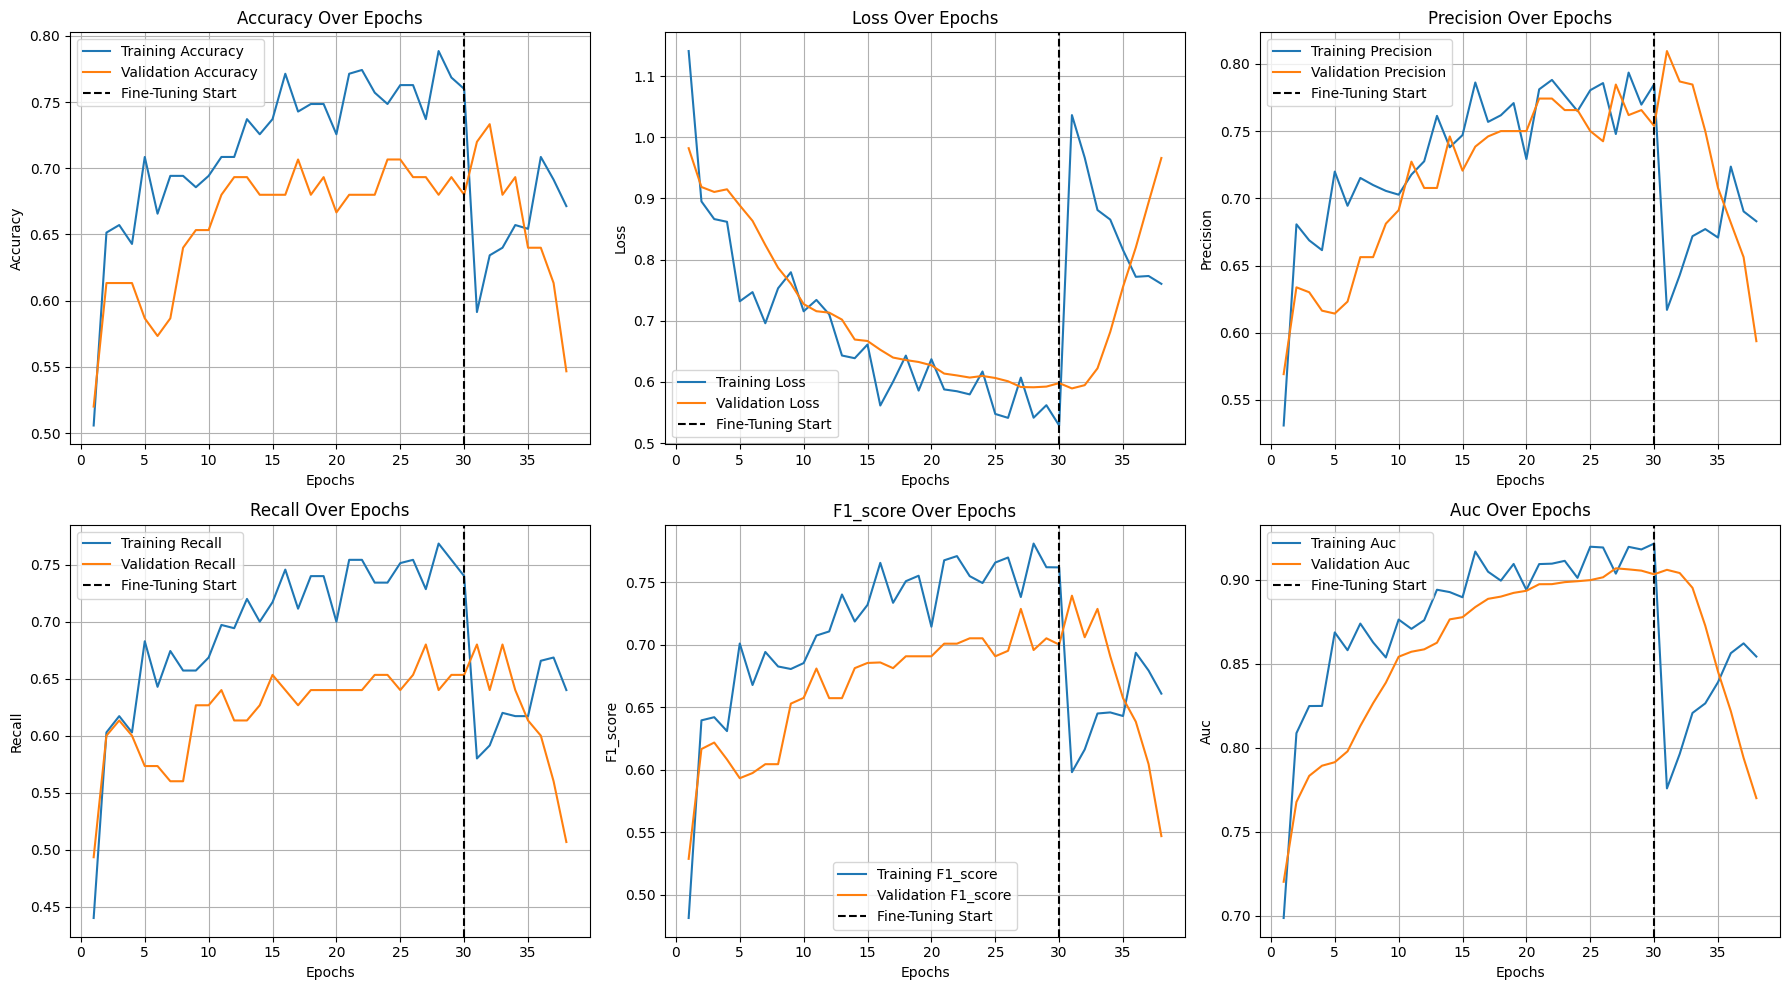

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(history, history_fine):
    # List of metrics to plot
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'f1_score', 'auc']

    # Find total epochs for separation
    initial_epochs = len(history.history['loss'])  # Number of initial training epochs

    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()  # Flatten to iterate easily over the axes

    # Combine history dictionaries for seamless plotting
    full_history = {metric: history.history.get(metric, []) + history_fine.history.get(metric, []) for metric in metrics}
    full_history.update({f'val_{metric}': history.history.get(f'val_{metric}', []) + history_fine.history.get(f'val_{metric}', []) for metric in metrics})

    # Plot each metric for both training and validation data
    for i, metric in enumerate(metrics):
        epochs = range(1, len(full_history[metric]) + 1)

        axes[i].plot(epochs, full_history[metric], label=f'Training {metric.capitalize()}')
        axes[i].plot(epochs, full_history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')

        # Add dashed line to separate initial training and fine-tuning phases
        axes[i].axvline(x=initial_epochs, linestyle='--', color='black', label='Fine-Tuning Start')

        axes[i].set_title(f'{metric.capitalize()} Over Epochs')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function to plot training and fine-tuning metrics
plot_training_metrics(history, history_fine)



**Confusion Matrix & Classification Report**

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


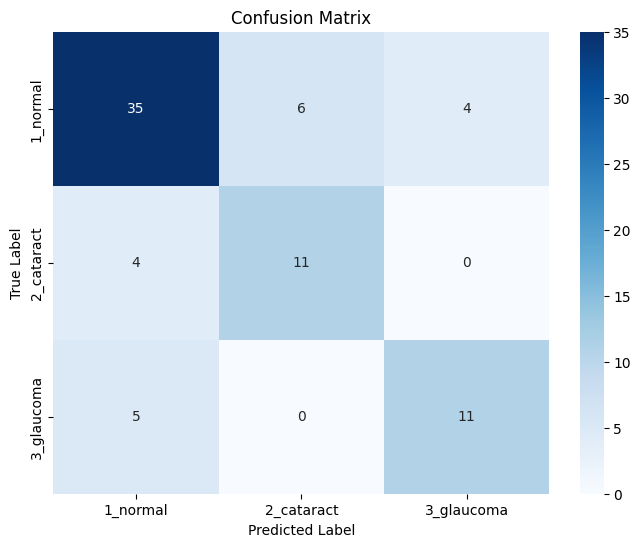

Classification Report:
               precision    recall  f1-score   support

    1_normal       0.80      0.78      0.79        45
  2_cataract       0.65      0.73      0.69        15
  3_glaucoma       0.73      0.69      0.71        16

    accuracy                           0.75        76
   macro avg       0.73      0.73      0.73        76
weighted avg       0.75      0.75      0.75        76



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reset the generator to ensure predictions start from the beginning.
test_generator.reset()

# Generate predictions for the test set.
# Compute the required steps based on the batch size.
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=steps)

# Convert predicted probabilities to class indices (highest probability class).
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve the true labels from the generator.
true_classes = test_generator.classes

# Retrieve the class labels (names) based on the dataset directory structure.
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix.
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate and print the classification report.
report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=2)
print("Classification Report:\n", report)


**ROC curve**

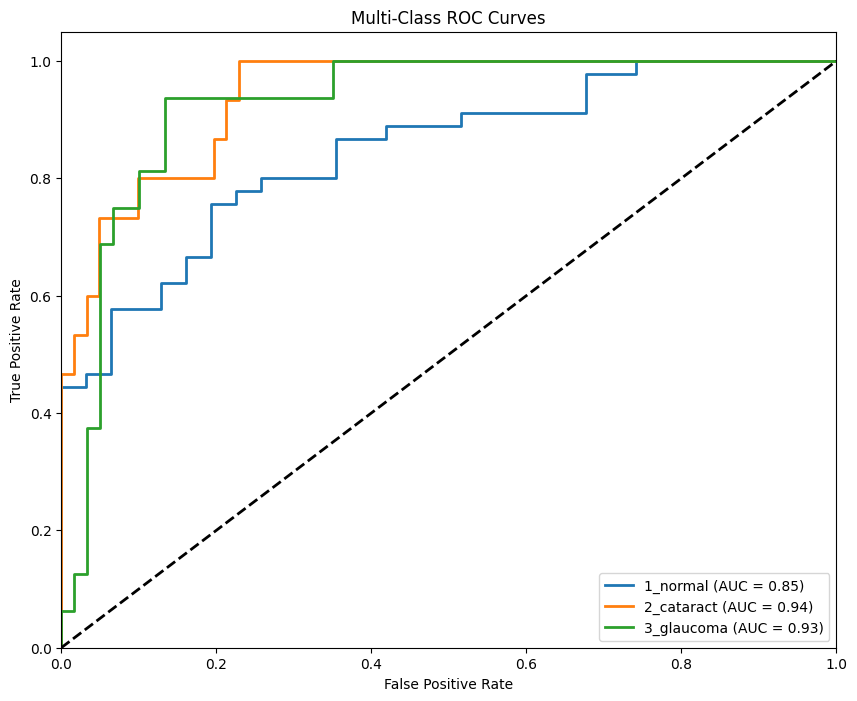

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Convert true labels to one-hot encoding.
# 'class_labels' is the list of class names retrieved earlier.
num_classes = len(class_labels)
y_true = to_categorical(test_generator.classes, num_classes=num_classes)

# 'predictions' were generated earlier using model.predict(...)
y_pred = predictions  # Shape: (n_samples, num_classes)

# Compute ROC curve and AUC for each class.
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.show()

**Precision-Recall curve**

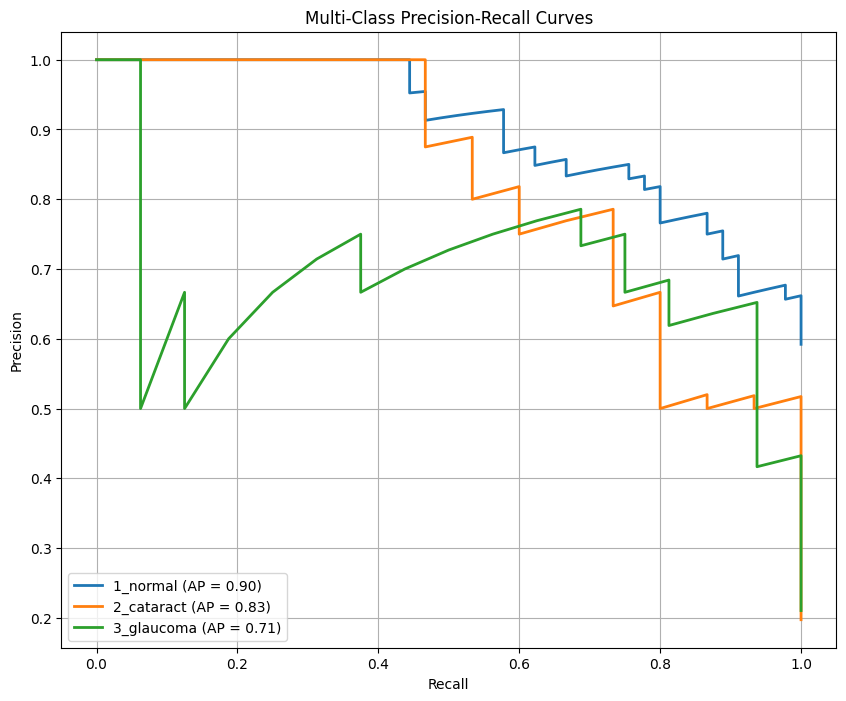

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curves and average precision (AP) for each class.
precision_dict = {}
recall_dict = {}
average_precision = {}

for i in range(num_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# Plot the Precision-Recall curves for each class.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(recall_dict[i], precision_dict[i], lw=2, label=f'{label} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curves')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


**Test Predictions Visualization**

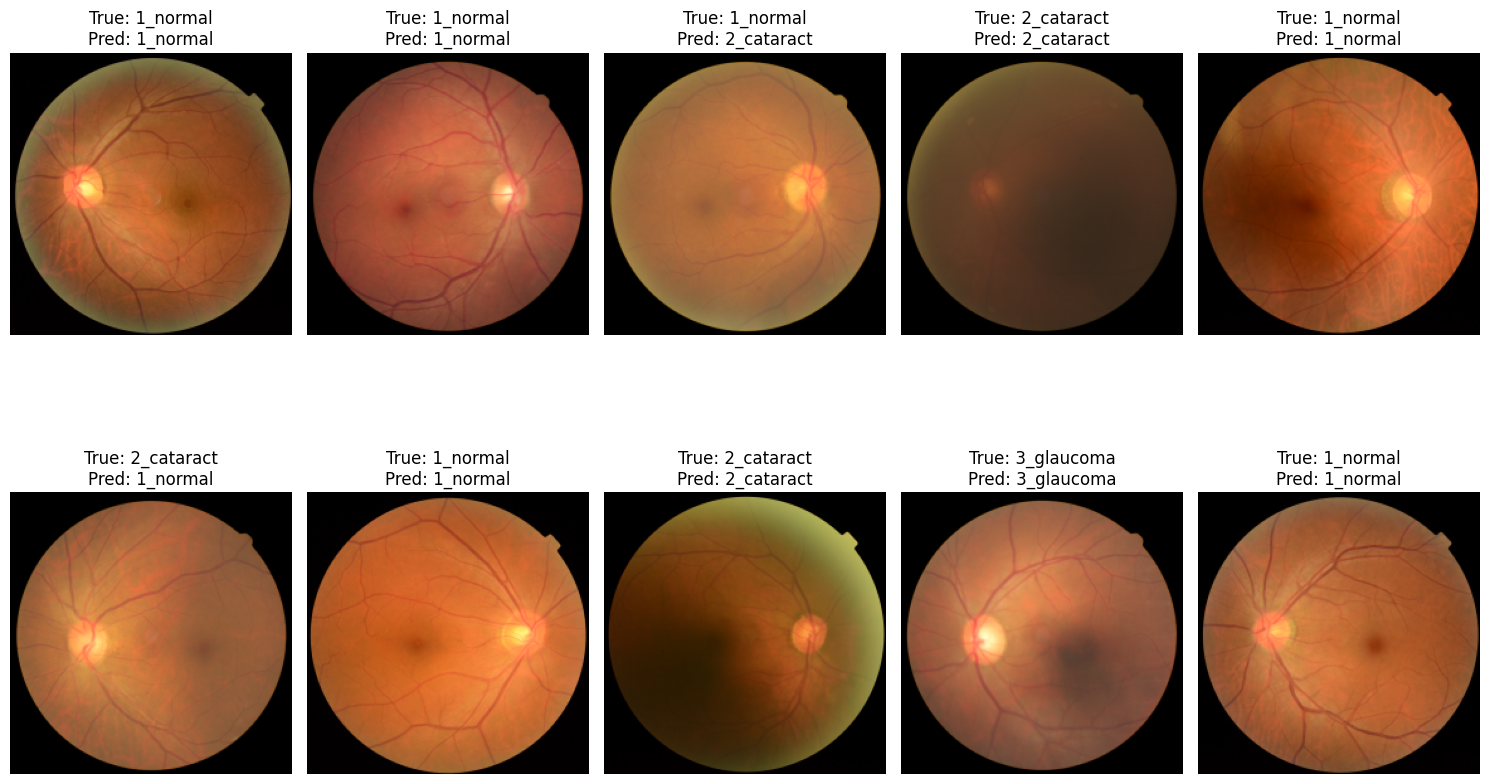

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Ensure predictions is computed earlier using model.predict(...).
# Convert predictions (probabilities) to integer class indices.
predicted_labels = np.argmax(predictions, axis=1)

# Get image file paths and true labels from the test generator.
test_images, test_labels = test_generator.filepaths, test_generator.classes

# Randomly sample 10 test images.
sample_indices = random.sample(range(len(test_images)), 10)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    img_path = test_images[idx]
    true_label = class_labels[test_labels[idx]]
    pred_label = class_labels[predicted_labels[idx]]

    # Load and display the image.
    img = plt.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPred: {pred_label}')

plt.tight_layout()
plt.show()

# **Preprocessing Phase 2**

**Splitting dataset to 60:20:20 ratio**

In [ ]:
def split_dataset_proportionally(input_dir, output_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        files = os.listdir(class_path)
        random.shuffle(files)  # Shuffle to ensure random distribution

        # Calculate split sizes
        train_split = int(len(files) * train_ratio)
        val_split = int(len(files) * (train_ratio + val_ratio))

        train_files = files[:train_split]
        val_files = files[train_split:val_split]
        test_files = files[val_split:]

        # Create output directories for each split
        os.makedirs(os.path.join(output_dir, 'train', class_name), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'val', class_name), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'test', class_name), exist_ok=True)

        # Move files to respective directories
        for f in train_files:
            shutil.copy(os.path.join(class_path, f), os.path.join(output_dir, 'train', class_name, f))
        for f in val_files:
            shutil.copy(os.path.join(class_path, f), os.path.join(output_dir, 'val', class_name, f))
        for f in test_files:
            shutil.copy(os.path.join(class_path, f), os.path.join(output_dir, 'test', class_name, f))

        # Print status
        print(f"Class '{class_name}': {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

# Paths
input_dir = './raw_data'  # Directory containing resized images
output_dir = './raw_data_split'  # Output directory for split datasets

# Split the dataset
split_dataset_proportionally(input_dir, output_dir)


Class '1_normal': 180 train, 60 val, 60 test
Class '2_cataract': 60 train, 20 val, 20 test
Class '3_glaucoma': 60 train, 20 val, 21 test


**Balancing dataset to 300 images per class by augmentation**

In [ ]:
# Paths
input_dir = './raw_data_split/train'  # Original dataset directory
output_dir = './raw_data_split/train_augmented'  # Directory to save augmented images
target_size = 300  # Desired number of images per class

# ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Augmentation strategy
augmentation_config = {
    '1_normal': 2,  # Generate 2 augmented images per input image
    '2_cataract': 4,  # Generate 4 augmented images per input image
    '3_glaucoma': 4   # Generate 4 augmented images per input image
}

# Loop through each class directory
for class_name in os.listdir(input_dir):
    class_input_path = os.path.join(input_dir, class_name)
    class_output_path = os.path.join(output_dir, class_name)

    # Ensure the output class directory exists
    if not os.path.exists(class_output_path):
        os.makedirs(class_output_path)

    # Copy original images to the output directory
    images = os.listdir(class_input_path)
    for img_name in images:
        input_img_path = os.path.join(class_input_path, img_name)
        output_img_path = os.path.join(class_output_path, img_name)
        shutil.copy(input_img_path, output_img_path)

    # Count images now in the output directory (includes original images)
    image_count = len(os.listdir(class_output_path))

    # Determine augmentation multiplier based on class
    augmentation_multiplier = augmentation_config.get(class_name, 1)  # Default to 1 if class not in config

    # Augment images if the count is below the target size
    if image_count < target_size:
        print(f"Augmenting class: {class_name} ({image_count}/{target_size})")
        for img_name in images:
            img_path = os.path.join(class_input_path, img_name)
            img = load_img(img_path)  # Load image
            img_array = img_to_array(img)  # Convert to array
            img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for augmentation

            # Generate augmented images
            save_prefix = os.path.splitext(img_name)[0]
            generated_images = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_output_path,
                                      save_prefix=save_prefix, save_format='png'):
                generated_images += 1
                if generated_images >= augmentation_multiplier:
                    break

            # Update the image count
            image_count += augmentation_multiplier
            if image_count >= target_size:
                break

        print(f"Class {class_name} balanced to {target_size} images.")
    else:
        print(f"Class {class_name} already has {image_count} images. No augmentation needed.")

        # Validate the number of files in the output directory
    final_image_count = len(os.listdir(class_output_path))
    print(f"Final file count in '{class_name}': {final_image_count} files.")


Augmenting class: 1_normal (180/300)
Class 1_normal balanced to 300 images.
Final file count in '1_normal': 300 files.
Augmenting class: 2_cataract (60/300)
Class 2_cataract balanced to 300 images.
Final file count in '2_cataract': 300 files.
Augmenting class: 3_glaucoma (60/300)
Class 3_glaucoma balanced to 300 images.
Final file count in '3_glaucoma': 300 files.


# **Experiment 2**
#**Balanced Dataset Testing with DenseNet-121 (no CLAHE filtering)**
**Fine-tuning to the whole base model**

**Training Strategy**

The model leverages DenseNet121, which has been pre-trained on ImageNet, as a feature extractor. Initially, the base model's weights are frozen. This allows the newly added custom layers (global average pooling, batch normalization, dropout, and dense layers) to learn task-specific features without disrupting the pre-trained representations of the base model (initially trained on ImageNet dataset).

*   **Initial Training Phase:**
In the initial training phase, only the custom classification layers are trained for 30 epochs. During this phase, class weights are applied (see below) to help balance the contributions of each class. The training uses callbacks such as ReduceLROnPlateau (to lower the learning rate when validation loss plateaus) and EarlyStopping (to halt training if the validation loss does not improve).
*   **Fine-Tuning Phase:**
After the initial training, the DenseNet121 base model is unfrozen, and the entire network is recompiled with a lower learning rate (1e-5). Fine-tuning is then performed for an additional 20 epochs. This phase allows the pre-trained weights to be slightly adjusted (fine-tuned) to better capture the features specific to your dataset, often resulting in improved performance.

**Class Weights:**
Class weights are used to address the issue of missclassification between the normal and glaucoma classes in the dataset. When some classes are underrepresented or harder to classify, the model might tend to favor the majority class. By assigning higher weights to harder to classify classes, the loss function penalizes their misclassification more heavily. This encourages the model to pay more attention to learning the characteristics of glaucoma and cataract classes.



In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

# --- Enable GPU Memory Growth ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# --- Custom F1 Score Metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


# --- Paths ---
train_dir = './dataset_split2/train_augmented'
val_dir = './dataset_split2/val'
test_dir = './dataset_split2/test'
IMG_SIZE = (224, 224)

# --- Hyperparameters ---
BATCH_SIZE = 32
LEARNING_RATE = 0.00016084
DROPOUT_RATE_1 = 0.3
DROPOUT_RATE_2 = 0.5
DENSE_UNITS = 512
EPOCHS = 30
FINE_TUNE_EPOCHS = 20

# --- Class Weights ---
class_weights = {
    0: 1.0,
    1: 2.0,
    2: 2.0
}

# --- Build Model ---
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_RATE_1)(x)
    x = Dense(DENSE_UNITS, activation='relu')(x)
    x = Dropout(DROPOUT_RATE_2)(x)
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc'),
            F1Score(name='f1_score')
        ]
    )
    model.base_model = base_model
    return model

# --- Data Generators ---
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# --- Initialize the Model ---
model = build_model()

# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

# --- Train the Model (Initial Phase) ---
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

# --- Fine-Tuning Phase ---
model.base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        F1Score(name='f1_score')
    ]
)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

# --- Evaluate on Test Data ---
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(test_generator)
print(f"Test Results: Accuracy={test_accuracy:.2f}, Precision={test_precision:.2f}, Recall={test_recall:.2f}, Loss={test_loss:.2f}, AUC={test_auc:.2f}, F1 Score={test_f1:.2f}")



**Training and Validation Metrics Over Epochs**

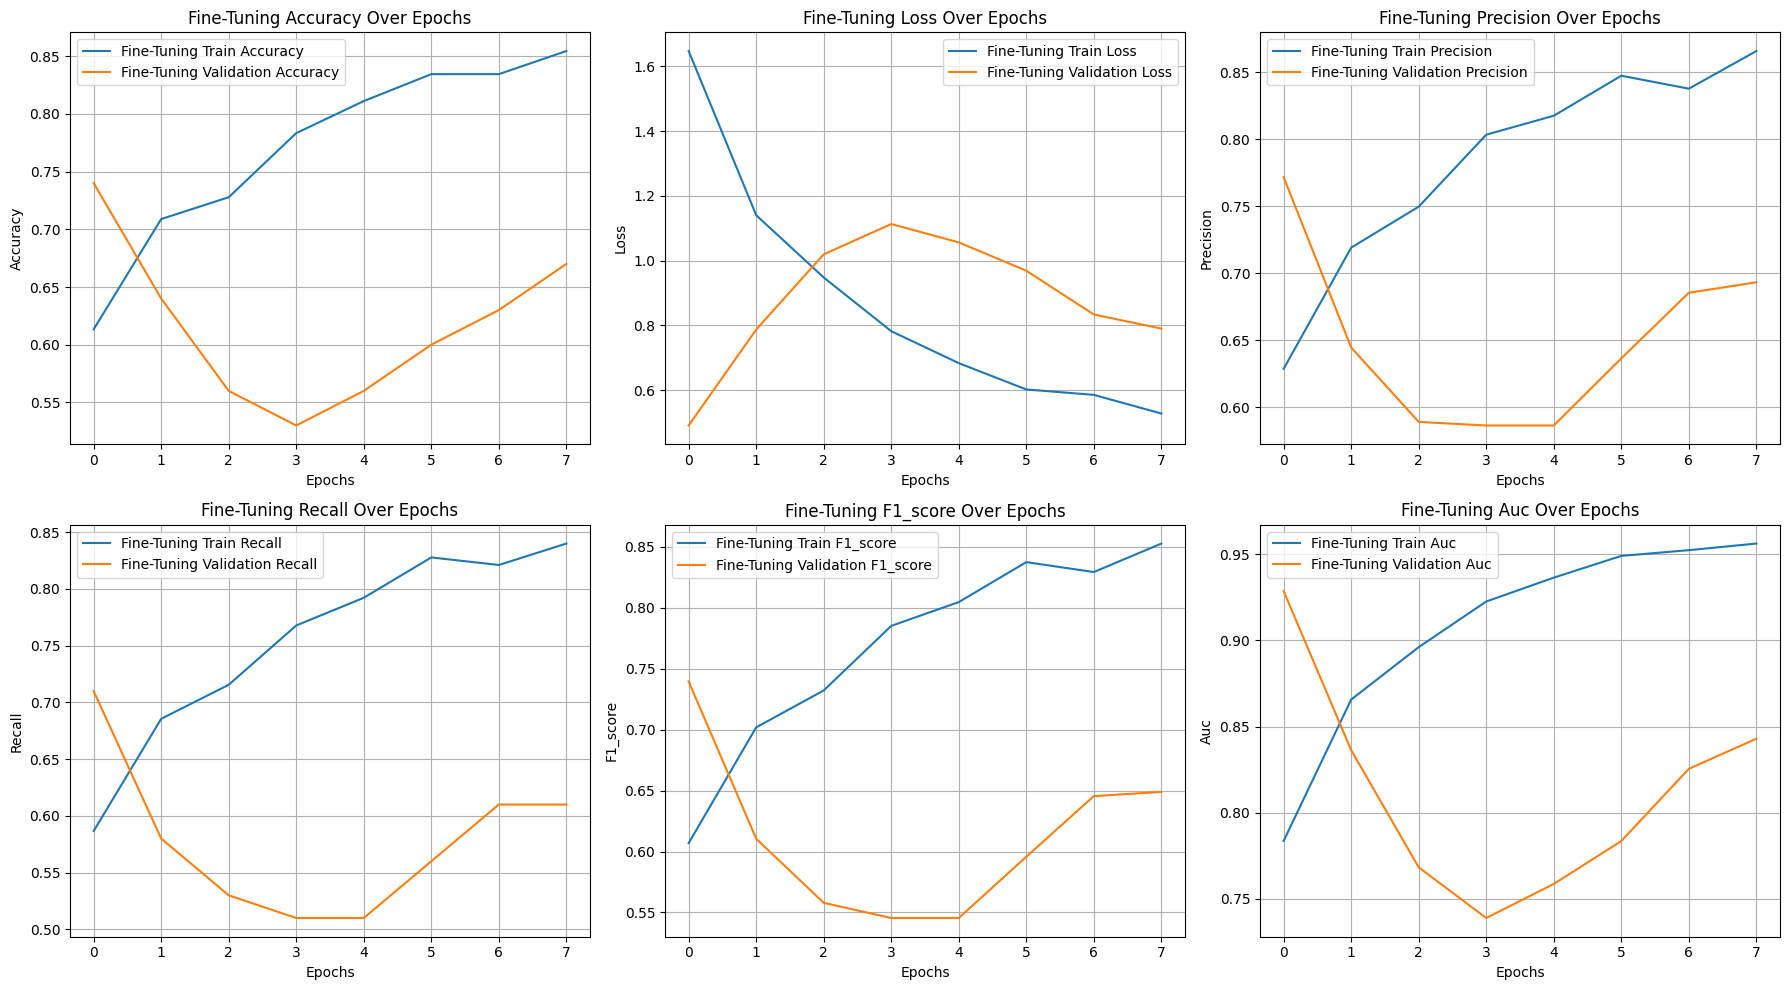

In [ ]:
import matplotlib.pyplot as plt

def plot_finetune_metrics(history_fine):
    # List of metrics to plot
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'f1_score', 'auc']

    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()  # Flatten to iterate easily over the axes

    # Plot each metric for both training and validation data
    for i, metric in enumerate(metrics):
        axes[i].plot(history_fine.history[metric], label=f'Fine-Tuning Train {metric.capitalize()}')
        axes[i].plot(history_fine.history[f'val_{metric}'], label=f'Fine-Tuning Validation {metric.capitalize()}')
        axes[i].set_title(f'Fine-Tuning {metric.capitalize()} Over Epochs')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel(metric.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function to plot fine tuning metrics
plot_finetune_metrics(history_fine)


**Confusion Matrix & Classification Report**

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step


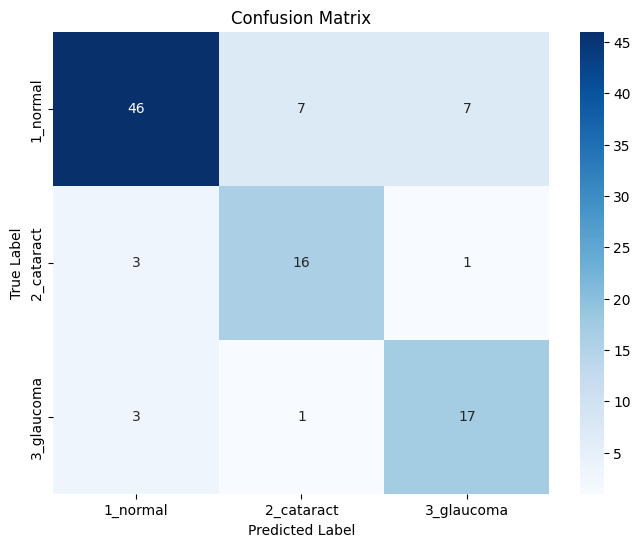

Classification Report:
               precision    recall  f1-score   support

    1_normal       0.88      0.77      0.82        60
  2_cataract       0.67      0.80      0.73        20
  3_glaucoma       0.68      0.81      0.74        21

    accuracy                           0.78       101
   macro avg       0.74      0.79      0.76       101
weighted avg       0.80      0.78      0.79       101



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reset the generator to ensure predictions start from the beginning.
test_generator.reset()

# Generate predictions for the test set.
# The number of steps is calculated using np.ceil to cover all test samples.
predictions = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)))
# For multi-class classification, choose the index with the highest probability.
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the generator.
true_classes = test_generator.classes

# Retrieve the class labels (names) based on the directory structure.
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix.
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate and print the classification report.
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

**ROC curve**

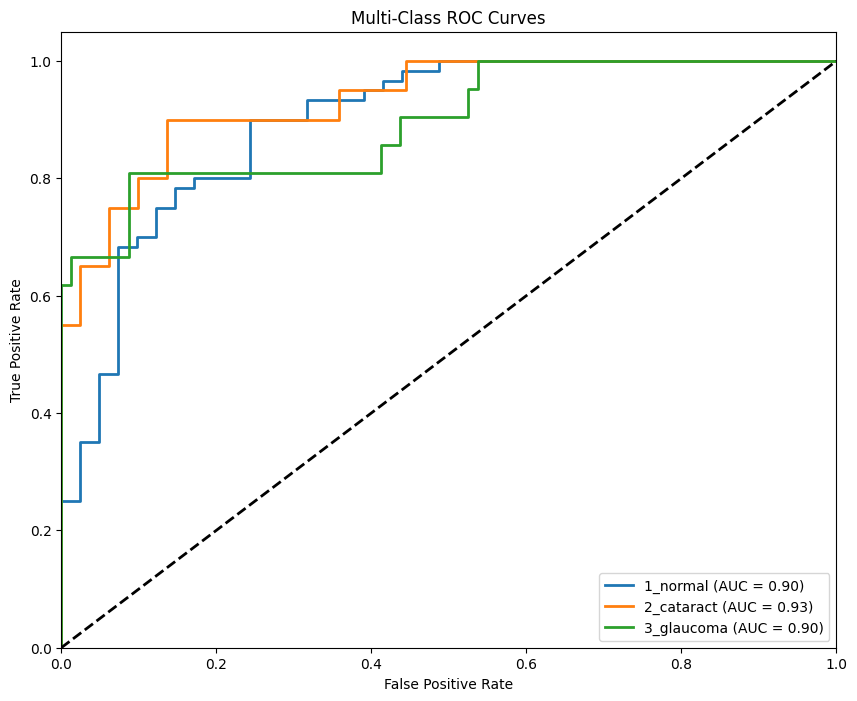

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Convert true labels to one-hot encoding.
# 'class_labels' is the list of class names retrieved earlier.
num_classes = len(class_labels)
y_true = to_categorical(test_generator.classes, num_classes=num_classes)

# 'predictions' were generated earlier using model.predict(...)
y_pred = predictions  # Shape: (n_samples, num_classes)

# Compute ROC curve and AUC for each class.
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.show()

**Precision-Recall curve**

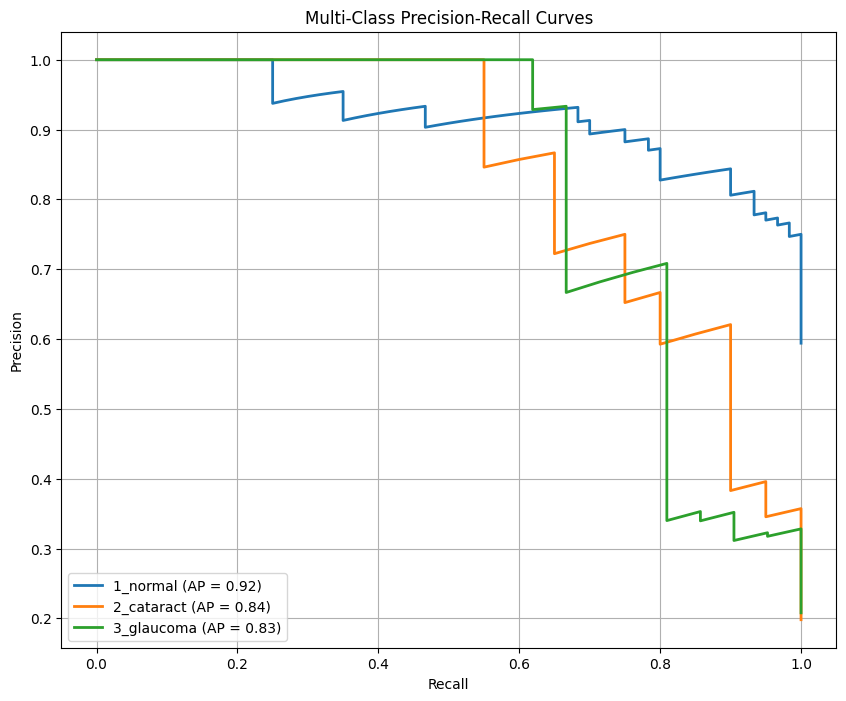

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curves and average precision (AP) for each class.
precision_dict = {}
recall_dict = {}
average_precision = {}

for i in range(num_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# Plot the Precision-Recall curves for each class.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(recall_dict[i], precision_dict[i], lw=2, label=f'{label} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curves')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

**Validation Accuracy and Loss over Epoch**

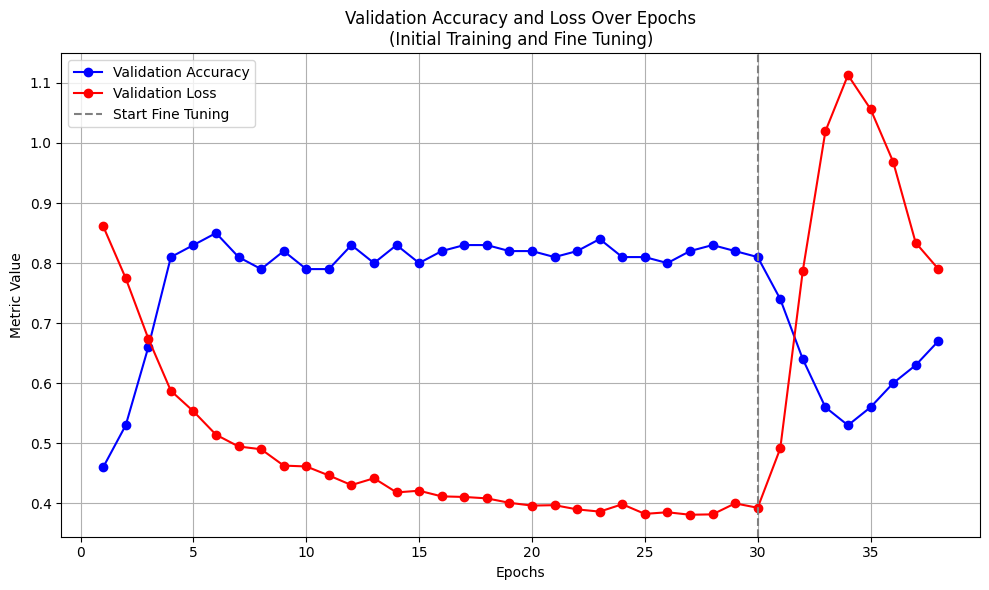

In [ ]:
import matplotlib.pyplot as plt

def plot_validation_metrics(initial_history, fine_history):
    """
    Plots combined validation accuracy and loss from the initial training phase
    and the fine-tuning phase on a single graph.

    Parameters:
      initial_history: History object from initial training.
      fine_history: History object from fine-tuning.
    """
    # Determine the number of epochs in each phase.
    initial_epochs = len(initial_history.history['val_accuracy'])
    fine_epochs = len(fine_history.history['val_accuracy'])
    total_epochs = initial_epochs + fine_epochs

    # Create a combined x-axis from 1 to total_epochs.
    epochs = range(1, total_epochs + 1)

    # Combine the validation accuracy and loss values.
    val_accuracy_total = initial_history.history['val_accuracy'] + fine_history.history['val_accuracy']
    val_loss_total = initial_history.history['val_loss'] + fine_history.history['val_loss']

    # Create the plot.
    plt.figure(figsize=(10, 6))

    # Plot validation accuracy and loss.
    plt.plot(epochs, val_accuracy_total, label='Validation Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_loss_total, label='Validation Loss', color='red', marker='o')

    # Mark the transition point between initial training and fine-tuning.
    plt.axvline(x=initial_epochs, color='gray', linestyle='--', label='Start Fine Tuning')

    # Add labels and title.
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('Validation Accuracy and Loss Over Epochs\n(Initial Training and Fine Tuning)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function with your history objects.
plot_validation_metrics(history, history_fine)


**Test Predictions Visualization**

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step


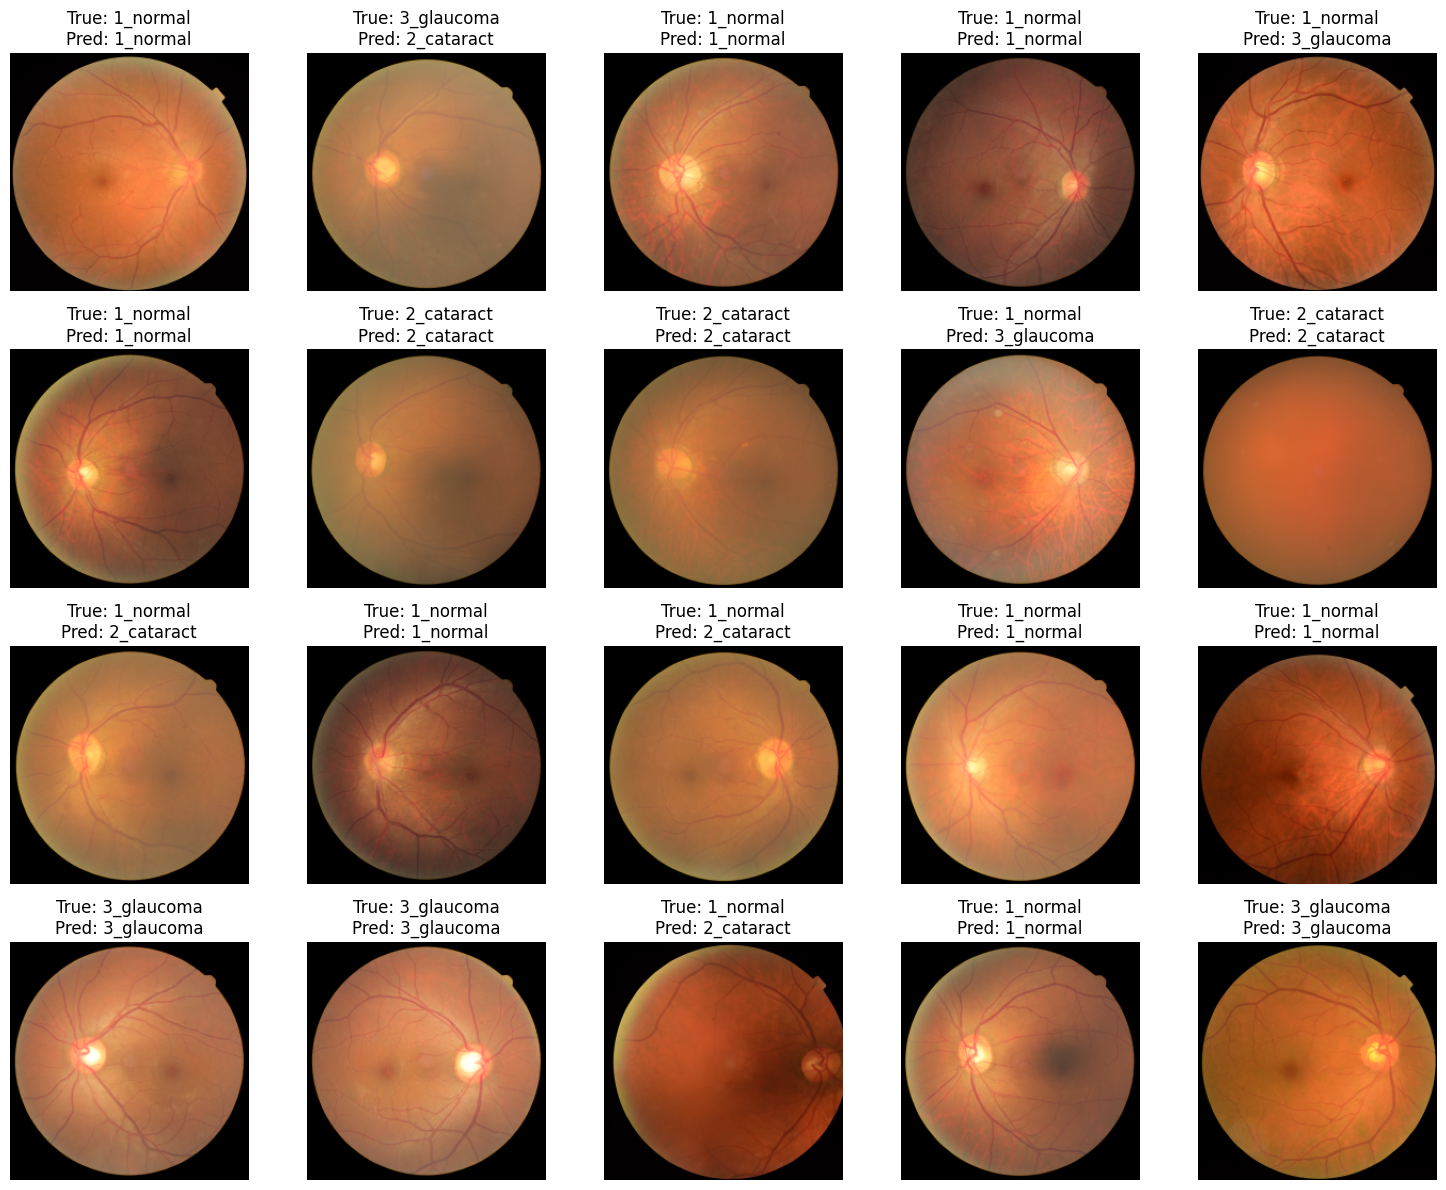

In [ ]:
import random
import matplotlib.pyplot as plt

# --- Compute predictions on the test set ---
predictions = model.predict(test_generator)

# Convert predictions to integer class indices.
predicted_labels = np.argmax(predictions, axis=1)

# Retrieve file paths and true labels from the test generator.
test_images = test_generator.filepaths
test_labels = test_generator.classes

# Create a mapping from class indices to class names.
# This relies on the directory names, which are stored in the generator's class_indices.
class_labels = list(test_generator.class_indices.keys())

# --- Randomly Sample 20 Test Images ---
sample_indices = random.sample(range(len(test_images)), 20)

# Set up a figure to display images in a 4 x 5 grid.
plt.figure(figsize=(15, 12))
for i, idx in enumerate(sample_indices):
    img_path = test_images[idx]
    true_label = class_labels[test_labels[idx]]
    pred_label = class_labels[predicted_labels[idx]]

    # Load the image using matplotlib.
    img = plt.imread(img_path)

    # Create subplot for each image.
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}")

plt.tight_layout()
plt.show()


# **Preprocessing Phase 3**

**Applying CLAHE filtering to Split Dataset**

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def apply_milder_clahe_to_directory(input_dir, output_dir, clip_limit=1.5, tile_grid_size=(8, 8)):
    """
    Applies CLAHE (Contrast Limited Adaptive Histogram Equalization) to all images in the specified directory.

    Args:
        input_dir (str): Path to the input directory containing class subdirectories.
        output_dir (str): Path to the output directory where processed images will be saved.
        clip_limit (float): Threshold for contrast limiting.
        tile_grid_size (tuple): Size of the grid for histogram equalization.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_name in os.listdir(input_dir):
        class_input_path = os.path.join(input_dir, class_name)
        class_output_path = os.path.join(output_dir, class_name)

        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)

        for img_name in os.listdir(class_input_path):
            img_path = os.path.join(class_input_path, img_name)
            output_path = os.path.join(class_output_path, img_name)

            img = cv2.imread(img_path)
            if img is not None:
                # Convert to LAB color space
                lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)

                # Apply CLAHE only on the L channel (lightness)
                clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
                l_clahe = clahe.apply(l)

                # Merge the channels back and convert to BGR
                lab_clahe = cv2.merge((l_clahe, a, b))
                img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

                # Save the processed image
                cv2.imwrite(output_path, img_clahe)
            else:
                print(f"Warning: Could not read image {img_path}")


# Paths for Train, Validation, and Test Datasets
train_dir = './raw_data_split/train'
val_dir = './raw_data_split/val'
test_dir = './raw_data_split/test'

# Output Paths for Processed Datasets
train_clahe_dir = './raw_data_split/train_clahe'
val_clahe_dir = './raw_data_split/val_clahe'
test_clahe_dir = './raw_data_split/test_clahe'

# Apply Milder CLAHE to All Datasets
apply_milder_clahe_to_directory(train_dir, train_clahe_dir, clip_limit=1.5, tile_grid_size=(8, 8))
apply_milder_clahe_to_directory(val_dir, val_clahe_dir, clip_limit=1.5, tile_grid_size=(8, 8))
apply_milder_clahe_to_directory(test_dir, test_clahe_dir, clip_limit=1.5, tile_grid_size=(8, 8))

print("CLAHE processing complete for Train, Validation, and Test datasets.")

CLAHE processing complete for Train, Validation, and Test datasets.


**Balancing CLAHE processed training split to 300 images per class by augmentation**

In [ ]:
# Paths
input_dir = './raw_data_split/train_clahe'
output_dir = './raw_data_split/train_augmented_clahe'  # Directory to save augmented images
target_size = 300  # Desired number of images per class

# ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Augmentation strategy
augmentation_config = {
    '1_normal': 2,  # Generate 2 augmented images per input image
    '2_cataract': 4,  # Generate 4 augmented images per input image
    '3_glaucoma': 4   # Generate 4 augmented images per input image
}

# Loop through each class directory
for class_name in os.listdir(input_dir):
    class_input_path = os.path.join(input_dir, class_name)
    class_output_path = os.path.join(output_dir, class_name)

    # Ensure the output class directory exists
    if not os.path.exists(class_output_path):
        os.makedirs(class_output_path)

    # Copy original images to the output directory
    images = os.listdir(class_input_path)
    for img_name in images:
        input_img_path = os.path.join(class_input_path, img_name)
        output_img_path = os.path.join(class_output_path, img_name)
        shutil.copy(input_img_path, output_img_path)

    # Count images now in the output directory (includes original images)
    image_count = len(os.listdir(class_output_path))

    # Determine augmentation multiplier based on class
    augmentation_multiplier = augmentation_config.get(class_name, 1)  # Default to 1 if class not in config

    # Augment images if the count is below the target size
    if image_count < target_size:
        print(f"Augmenting class: {class_name} ({image_count}/{target_size})")
        for img_name in images:
            img_path = os.path.join(class_input_path, img_name)
            img = load_img(img_path)  # Load image
            img_array = img_to_array(img)  # Convert to array
            img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for augmentation

            # Generate augmented images
            save_prefix = os.path.splitext(img_name)[0]
            generated_images = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_output_path,
                                      save_prefix=save_prefix, save_format='png'):
                generated_images += 1
                if generated_images >= augmentation_multiplier:
                    break

            # Update the image count
            image_count += augmentation_multiplier
            if image_count >= target_size:
                break

        print(f"Class {class_name} balanced to {target_size} images.")
    else:
        print(f"Class {class_name} already has {image_count} images. No augmentation needed.")

        # Validate the number of files in the output directory
    final_image_count = len(os.listdir(class_output_path))
    print(f"Final file count in '{class_name}': {final_image_count} files.")


Augmenting class: 1_normal (180/300)
Class 1_normal balanced to 300 images.
Final file count in '1_normal': 300 files.
Augmenting class: 2_cataract (60/300)
Class 2_cataract balanced to 300 images.
Final file count in '2_cataract': 300 files.
Augmenting class: 3_glaucoma (60/300)
Class 3_glaucoma balanced to 300 images.
Final file count in '3_glaucoma': 300 files.


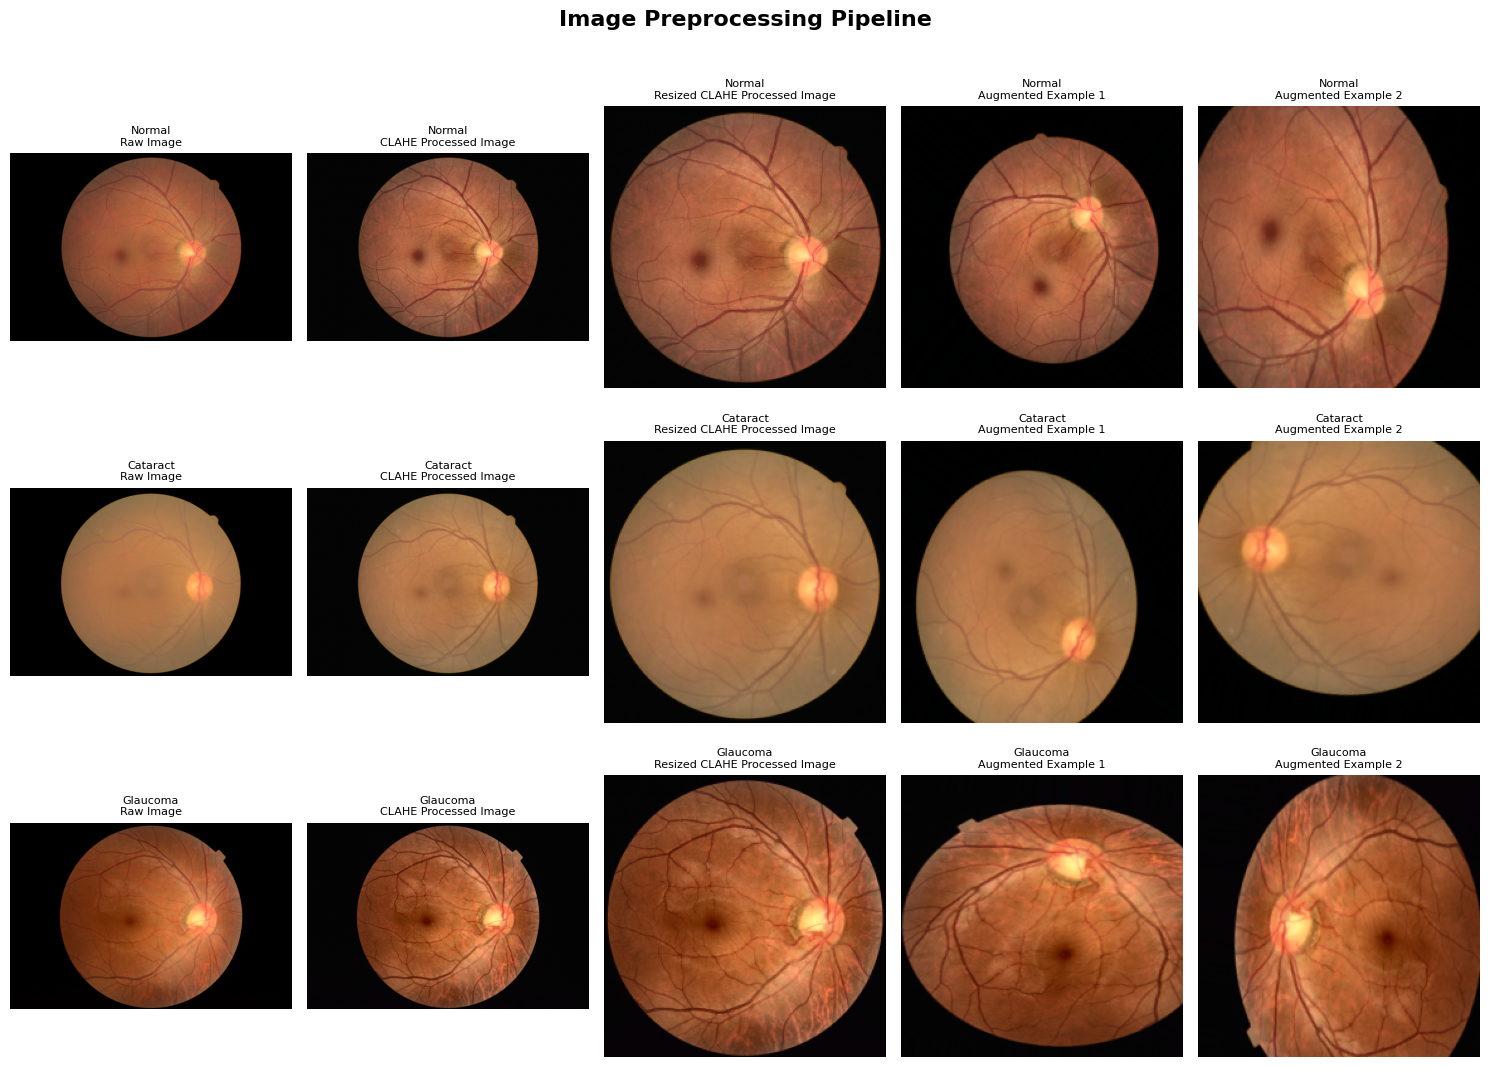

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image paths for each class and preprocessing step
image_paths = {
    "Normal": [
        "./raw_data_split/train/1_normal/NL_061.png",  # Raw image
        "./raw_data_split/train_clahe/1_normal/NL_061.png",  # CLAHE processed
        "./resized_clahe_images/train_clahe/1_normal/NL_061.png",  # Resized CLAHE processed
        "./resized_clahe_images/train_augmented_clahe/1_normal/NL_061_0_4836.png",  # Augmented example 1
        "./resized_clahe_images/train_augmented_clahe/1_normal/NL_061_0_51.png",  # Augmented example 2
    ],
    "Cataract": [
        "./raw_data_split/train/2_cataract/cataract_096.png",  # Raw image
        "./raw_data_split/train_clahe/2_cataract/cataract_096.png",  # CLAHE processed
        "./resized_clahe_images/train_clahe/2_cataract/cataract_096.png",  # Resized CLAHE processed
        "./resized_clahe_images/train_augmented_clahe/2_cataract/cataract_096_0_8519.png",  # Augmented example 1
        "./resized_clahe_images/train_augmented_clahe/2_cataract/cataract_096_0_5314.png",  # Augmented example 2
    ],
    "Glaucoma": [
        "./raw_data_split/train/3_glaucoma/Glaucoma_048.png",  # Raw image
        "./raw_data_split/train_clahe/3_glaucoma/Glaucoma_048.png",  # CLAHE processed
        "./resized_clahe_images/train_clahe/3_glaucoma/Glaucoma_048.png",  # Resized CLAHE processed
        "./resized_clahe_images/train_augmented_clahe/3_glaucoma/Glaucoma_048_0_8095.png",  # Augmented example 1
        "./resized_clahe_images/train_augmented_clahe/3_glaucoma/Glaucoma_048_0_7115.png",  # Augmented example 2
    ]
}

# Descriptions for each step
descriptions = [
    "Raw Image",
    "CLAHE Processed Image",
    "Resized CLAHE Processed Image",
    "Augmented Example 1",
    "Augmented Example 2",
]

# Plot settings
nrows = len(image_paths)  # One row per class
ncols = len(descriptions)  # Columns to match descriptions
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Set the main title for the plot
fig.suptitle("Image Preprocessing Pipeline", fontsize=16, weight="bold", y=1.08)

# Populate the plot with images
for row_idx, (label, paths) in enumerate(image_paths.items()):
    for col_idx, (path, desc) in enumerate(zip(paths, descriptions)):
        ax = axes[row_idx, col_idx] if nrows > 1 else axes[col_idx]
        try:
            img = mpimg.imread(path)
            ax.imshow(img)
            ax.set_title(f"{label}\n{desc}", fontsize=8)
        except FileNotFoundError:
            ax.text(0.5, 0.5, "Image Not Found", ha="center", va="center", fontsize=10)
        ax.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=1)  # Adjust space for the title
plt.show()


**Some directory paths might be different due to running various experiments that I haven't included to the final jupyter notebook.**

# **Experiment 3**
#**Balanced Dataset Testing with DenseNet-121 (CLAHE filtered)**
**Fine-tuning to the whole base model**

**Training Strategy**

This experiment introduces CLAHE preprocessing to enhance image contrast and refines the fine-tuning process through additional stability mechanisms. The primary modifications are:

*   **CLAHE filtering:** Contrast enhancement is applied to all images before training, which may improve feature extraction for retinal images.
*   **More structured fine-tuning strategy:** The fine-tuning phase now includes weight transfer, where the initial classifier head's trained weights are retained before re-initializing it.
*   **BatchNormalization layers remain frozen but their momentum is set to 0.9** for better adaptation during training. This allows some gradual adaptation without destabilizing the learned feature distribution.
*   **Learning rate warm-up phase:** Instead of using a fixed learning rate for fine-tuning, the model **gradually increases the learning rate over 12 epochs** before stabilizing it at **5e-6**.







In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# --- Enable GPU Memory Growth ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# --- Custom F1 Score Metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# --- Paths ---
train_dir = './resized_clahe_images/train_augmented_clahe'
val_dir   = './resized_clahe_images/val_clahe'
test_dir  = './resized_clahe_images/test_clahe'
IMG_SIZE  = (224, 224)

# --- Hyperparameters ---
BATCH_SIZE_TRAIN = 32
LEARNING_RATE    = 0.00016084
DROPOUT_RATE_1   = 0.3
DROPOUT_RATE_2   = 0.5
DENSE_UNITS      = 512
EPOCHS           = 30
FINE_TUNE_EPOCHS = 10

# --- Class Weights (to balance dataset) ---
class_weights = {0: 1.0, 1: 1.5, 2: 1.8}

# --- Data Generators for Image Loading ---
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen   = ImageDataGenerator(rescale=1.0/255)
test_datagen  = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE_TRAIN, class_mode='categorical', shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE_TRAIN, class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE_TRAIN, class_mode='categorical', shuffle=False
)

# --- Build Model for Initial Training ---
def build_initial_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model (feature extraction only)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_RATE_1)(x)
    x = Dense(DENSE_UNITS, activation='relu', name='dense')(x)
    x = Dropout(DROPOUT_RATE_2)(x)
    output = Dense(3, activation='softmax', name='dense_1')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')]
    )
    model.base_model = base_model  # Save reference for fine-tuning
    return model

model = build_initial_model()

# --- Callbacks for Initial Training ---
early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=10, restore_best_weights=True)
reduce_lr      = ReduceLROnPlateau(monitor='val_f1_score', mode='max', factor=0.5, patience=3, verbose=1)

# --- Initial Training (Feature Extraction) ---
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

# --- Fine-Tuning Phase ---
# Unfreeze DenseNet121 base model for full fine-tuning
model.base_model.trainable = True

# Keep BatchNormalization layers frozen to maintain stability
for layer in model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
        layer.momentum = 0.9

# Save pre-trained weights from initial training
dense_weights = model.get_layer('dense').get_weights()
output_weights = model.get_layer('dense_1').get_weights()

# Rebuild the classification head (without dropout)
inputs = model.base_model.input
x = model.base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(DENSE_UNITS, activation='relu', name='dense')(x)
x = Dense(3, activation='softmax', name='dense_1')(x)
fine_tune_model = Model(inputs=inputs, outputs=x)

# Transfer trained weights to the new classification head
fine_tune_model.get_layer('dense').set_weights(dense_weights)
fine_tune_model.get_layer('dense_1').set_weights(output_weights)

# --- Learning Rate Schedule for Fine-Tuning ---
warmup_epochs = 12  # Gradually increase LR
max_lr = 5e-6       # Stable learning rate after warm-up

def lr_schedule(epoch):
    if epoch < warmup_epochs:
        return 1e-7 * (10 ** (epoch / warmup_epochs))  # Exponential warm-up
    else:
        return max_lr  # Fixate learning rate at 5e-6

lr_callback = LearningRateScheduler(lr_schedule)

# Compile model with lower LR for fine-tuning
fine_tune_model.compile(
    optimizer=Adam(learning_rate=1e-7),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')]
)

# --- Fine-Tuning Training ---
fine_tune_history = fine_tune_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=FINE_TUNE_EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_callback]
)

# --- Evaluate on Test Data ---
results = fine_tune_model.evaluate(test_generator)
print("Test Results:", dict(zip(fine_tune_model.metrics_names, results)))




**Training and Validation Metrics Over Epochs**

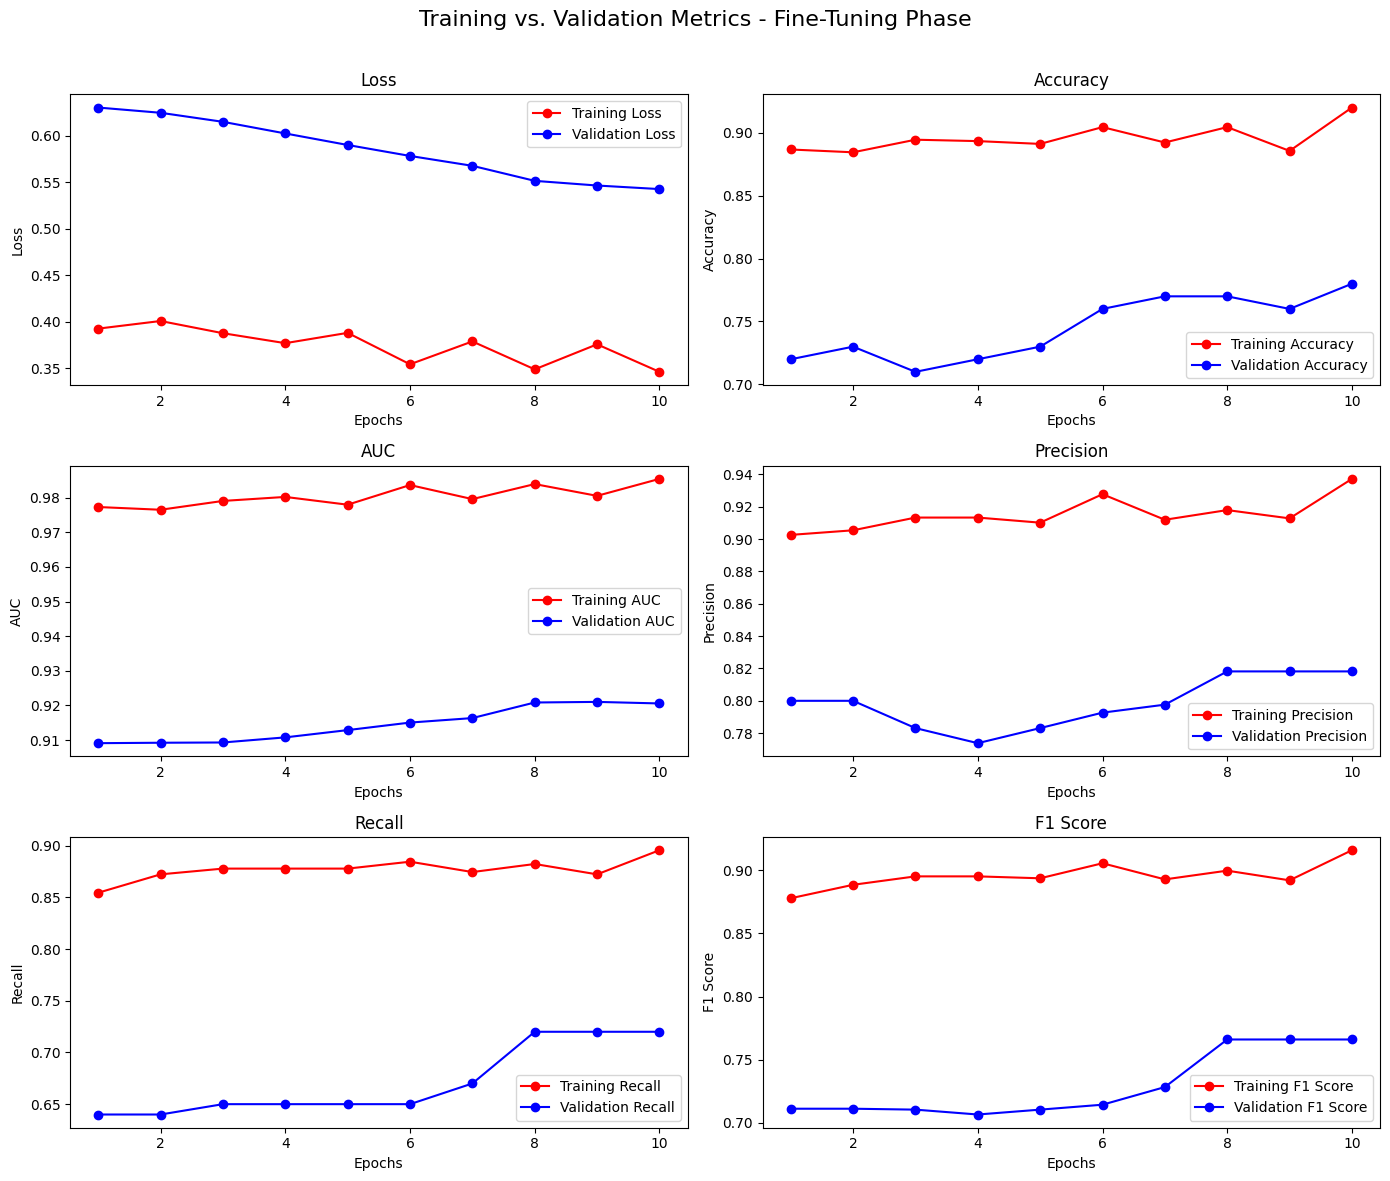

In [ ]:
import matplotlib.pyplot as plt

# Extract the number of epochs from the fine-tuning history.
epochs = range(1, len(fine_tune_history.history["loss"]) + 1)

# Create subplots: 3 rows and 2 columns.
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Training vs. Validation Metrics - Fine-Tuning Phase", fontsize=16)

# Plot Loss.
axes[0, 0].plot(epochs, fine_tune_history.history["loss"], label="Training Loss", color='red', marker='o')
axes[0, 0].plot(epochs, fine_tune_history.history["val_loss"], label="Validation Loss", color='blue', marker='o')
axes[0, 0].set_title("Loss")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()

# Plot Accuracy.
axes[0, 1].plot(epochs, fine_tune_history.history["accuracy"], label="Training Accuracy", color='red', marker='o')
axes[0, 1].plot(epochs, fine_tune_history.history["val_accuracy"], label="Validation Accuracy", color='blue', marker='o')
axes[0, 1].set_title("Accuracy")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].legend()

# Plot AUC.
axes[1, 0].plot(epochs, fine_tune_history.history["auc"], label="Training AUC", color='red', marker='o')
axes[1, 0].plot(epochs, fine_tune_history.history["val_auc"], label="Validation AUC", color='blue', marker='o')
axes[1, 0].set_title("AUC")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("AUC")
axes[1, 0].legend()

# Plot Precision.
axes[1, 1].plot(epochs, fine_tune_history.history["precision"], label="Training Precision", color='red', marker='o')
axes[1, 1].plot(epochs, fine_tune_history.history["val_precision"], label="Validation Precision", color='blue', marker='o')
axes[1, 1].set_title("Precision")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].legend()

# Plot Recall.
axes[2, 0].plot(epochs, fine_tune_history.history["recall"], label="Training Recall", color='red', marker='o')
axes[2, 0].plot(epochs, fine_tune_history.history["val_recall"], label="Validation Recall", color='blue', marker='o')
axes[2, 0].set_title("Recall")
axes[2, 0].set_xlabel("Epochs")
axes[2, 0].set_ylabel("Recall")
axes[2, 0].legend()

# Plot F1 Score.
axes[2, 1].plot(epochs, fine_tune_history.history["f1_score"], label="Training F1 Score", color='red', marker='o')
axes[2, 1].plot(epochs, fine_tune_history.history["val_f1_score"], label="Validation F1 Score", color='blue', marker='o')
axes[2, 1].set_title("F1 Score")
axes[2, 1].set_xlabel("Epochs")
axes[2, 1].set_ylabel("F1 Score")
axes[2, 1].legend()

# Adjust layout to prevent overlap and keep the main title visible.
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


**Confusion Matrix & Classification Report**

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


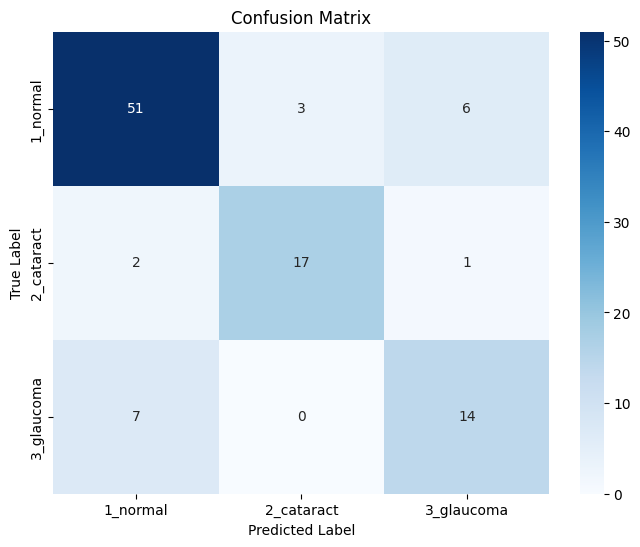

Classification Report:
               precision    recall  f1-score   support

    1_normal       0.85      0.85      0.85        60
  2_cataract       0.85      0.85      0.85        20
  3_glaucoma       0.67      0.67      0.67        21

    accuracy                           0.81       101
   macro avg       0.79      0.79      0.79       101
weighted avg       0.81      0.81      0.81       101



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reset the generator to ensure predictions start from the beginning.
test_generator.reset()

# Generate predictions for the test set.
# The number of steps is calculated using np.ceil to cover all test samples.
predictions = fine_tune_model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size)))
# For multi-class classification, choose the index with the highest probability.
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the generator.
true_classes = test_generator.classes

# Retrieve the class labels (names) based on the directory structure.
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix.
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Generate and print the classification report.
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

**ROC curve**

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


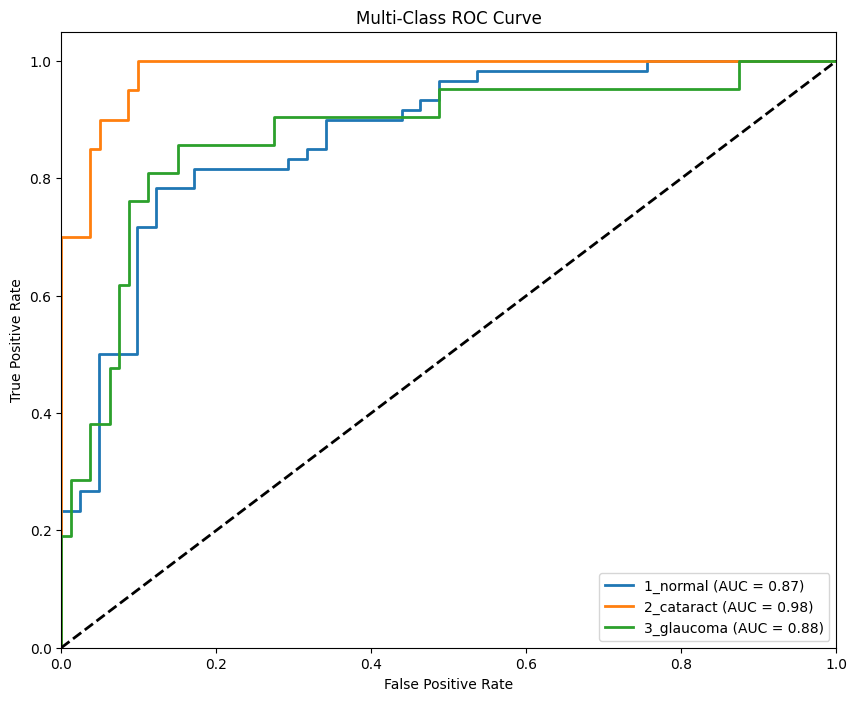

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the test set.
predictions = fine_tune_model.predict(test_generator)

# Get true class indices from the test generator.
true_classes = test_generator.classes

# Get class names from the class_indices dictionary.
class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# Convert true class indices to one-hot encoding.
y_true_onehot = to_categorical(true_classes, num_classes=num_classes)
y_pred = predictions  # Predicted probabilities

# Compute ROC curves and AUC for each class.
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier.
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

**Precision-Recall curve**

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


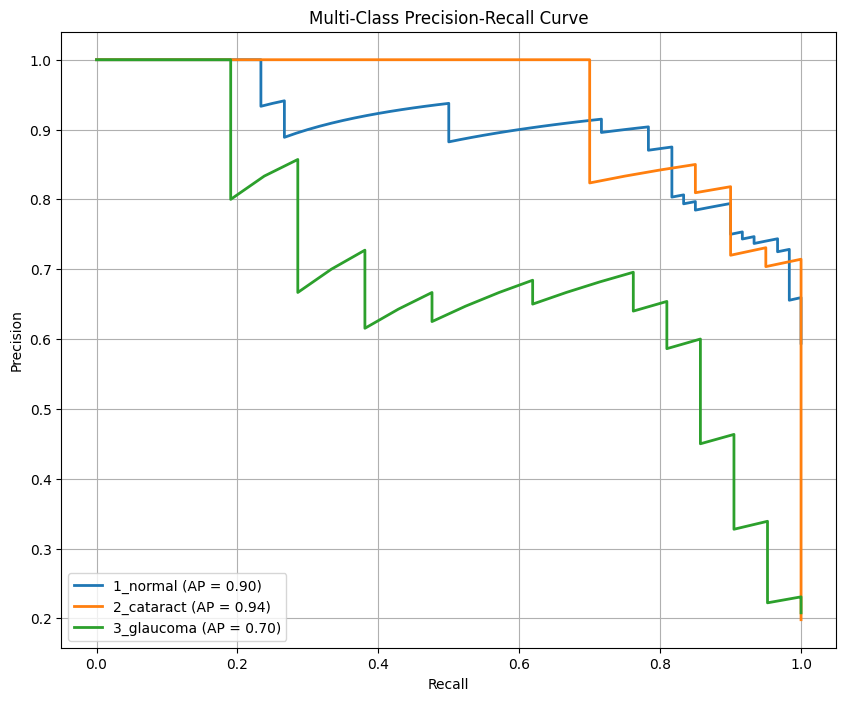

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np

# Get class names and number of classes.
class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# Get true class indices from test_generator.
true_classes = test_generator.classes

# Convert true classes to one-hot encoding.
y_true_onehot = to_categorical(true_classes, num_classes=num_classes)

# Generate predictions on the test set (predicted probabilities).
y_pred = fine_tune_model.predict(test_generator)

# Compute precision-recall curves and average precision for each class.
precision_dict = {}
recall_dict = {}
average_precision = {}
for i in range(num_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_true_onehot[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true_onehot[:, i], y_pred[:, i])

# Plot the precision-recall curves.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_names):
    plt.plot(recall_dict[i], precision_dict[i], lw=2, label=f'{label} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


**Validation Accuracy and Loss over Epoch**

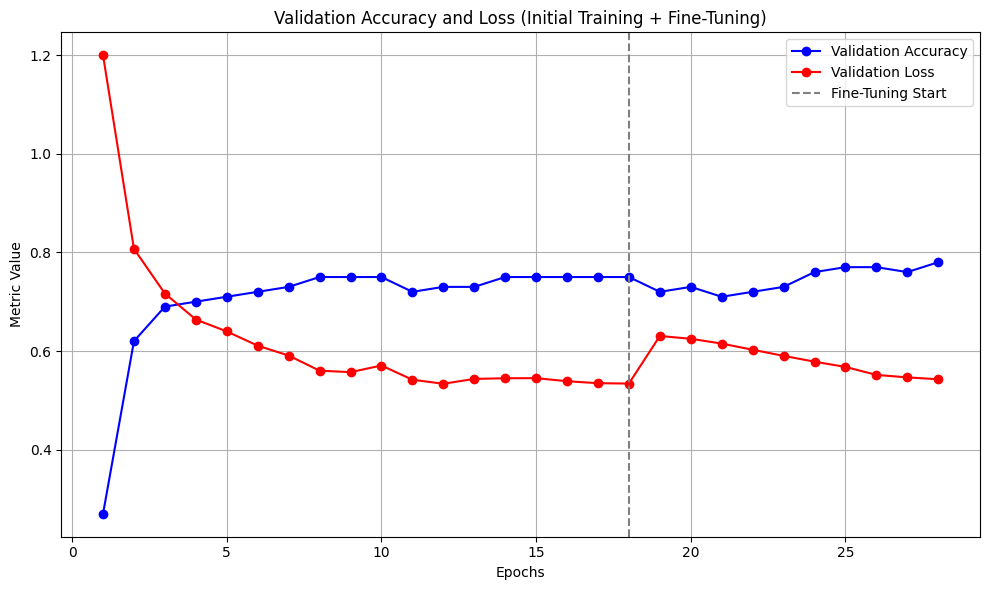

In [ ]:
import matplotlib.pyplot as plt

# Combine validation metrics from initial and fine-tuning phases.
initial_val_acc = history.history['val_accuracy']
initial_val_loss = history.history['val_loss']
fine_val_acc = fine_tune_history.history['val_accuracy']
fine_val_loss = fine_tune_history.history['val_loss']

total_epochs = len(initial_val_acc) + len(fine_val_acc)
epochs = range(1, total_epochs + 1)

combined_val_acc = initial_val_acc + fine_val_acc
combined_val_loss = initial_val_loss + fine_val_loss

plt.figure(figsize=(10, 6))
plt.plot(epochs, combined_val_acc, label='Validation Accuracy', marker='o', color='blue')
plt.plot(epochs, combined_val_loss, label='Validation Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Validation Accuracy and Loss (Initial Training + Fine-Tuning)')
plt.axvline(x=len(initial_val_acc), color='gray', linestyle='--', label='Fine-Tuning Start')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Test Predictions Visualization**

In [ ]:
import matplotlib.pyplot as plt
import random

# Get file paths and true labels from test_generator.
test_images = test_generator.filepaths
test_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Generate predictions if not already done.
predictions = fine_tune_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Randomly select 20 indices.
indices = random.sample(range(len(test_images)), 20)

plt.figure(figsize=(15, 12))
for i, idx in enumerate(indices):
    img_path = test_images[idx]
    true_label = class_names[test_labels[idx]]
    pred_label = class_names[predicted_labels[idx]]
    img = plt.imread(img_path)
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
plt.tight_layout()
plt.show()


# **Experiment 4**
#**Balanced Dataset Testing with DenseNet-121 (CLAHE filtered)**
**Fine-tuning to the last 82 layers of the base model**

**Training Strategy**

*   Unlike previous experiments, which fully fine-tuned the entire DenseNet121 base model, this script **unfreezes only the last 82 layers** for fine-tuning. This reduces the risk of overfitting while still allowing the model to learn more domain-specific features.

*   The fine-tuning phase starts with a **more conservative learning rate (1e-5)** for more drastic weight changes and gradual warm-up has been removed. Nonetheless, callbacks such as ReduceLROnPlateau (to lower the learning rate when validation loss plateaus) and EarlyStopping (to halt training if the validation loss does not improve) are still in place.

*   **Different class weights** have been implemented








In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- Custom F1 Score Metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


# --- Paths ---
train_dir = './resized_clahe_images/train_augmented_clahe'
val_dir = './resized_clahe_images/val_clahe'
test_dir = './resized_clahe_images/test_clahe'

IMG_SIZE = (224, 224)

# --- Hyperparameters ---
BATCH_SIZE = 64
BASE_LR = 0.00033609 # Initial Learning Rate
FINE_TUNE_LR = 0.00001  # Lower LR for fine-tuning
DROPOUT_RATE_1 = 0.3
DROPOUT_RATE_2 = 0.5
DENSE_UNITS = 384
EPOCHS = 30
FINE_TUNE_EPOCHS = 20

# --- Compute Class Weights for Imbalanced Dataset ---
class_weights = {
    0: 1.0,  # '1_normal'
    1: 1.9,  # '2_cataract'
    2: 2.1   # '3_glaucoma'
}

# --- Build Model ---
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Initially freeze the base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_RATE_1)(x)
    x = Dense(DENSE_UNITS, activation='relu')(x)
    x = Dropout(DROPOUT_RATE_2)(x)
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=BASE_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')]
    )
    return model


# --- Data Generators ---
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# --- Initialize the Model ---
model = build_model()

# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# --- Train the Model with Initial Frozen Base Layers ---
print("🚀 Training the model with frozen base layers...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

# --- Step 2: Unfreeze Last 82 Layers & Fine-Tune ---
print("🔧 Unfreezing the **last 82 layers** for fine-tuning...")
for layer in model.layers[-82:]:  # Unfreeze last 82 layers
    layer.trainable = True

# Recompile with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')]
)

# Train Again with Fine-Tuning
print("🚀 Fine-tuning the model...")
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

# --- Evaluate on Test Data ---
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(test_generator)
print(f"Test Results: Accuracy={test_accuracy:.2f}, Precision={test_precision:.2f}, Recall={test_recall:.2f}, Loss={test_loss:.2f}, AUC={test_auc:.2f}, F1 Score={test_f1:.2f}")


**Confusion Matrix & Classification Report**

2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 15s/step


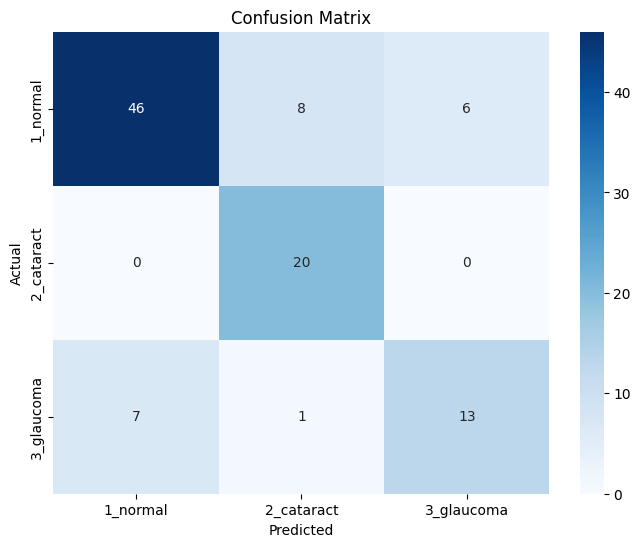


✅ Classification Report:

              precision    recall  f1-score   support

    1_normal       0.87      0.77      0.81        60
  2_cataract       0.69      1.00      0.82        20
  3_glaucoma       0.68      0.62      0.65        21

    accuracy                           0.78       101
   macro avg       0.75      0.80      0.76       101
weighted avg       0.79      0.78      0.78       101



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_generator):
    # Get true labels
    y_true = test_generator.classes

    # Get predicted probabilities
    y_pred_probs = model.predict(test_generator)

    # Convert probabilities to class predictions
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    labels = list(test_generator.class_indices.keys())

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("\n✅ Classification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=labels))

# Call the function
plot_confusion_matrix(model, test_generator)

**ROC curve**

2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step


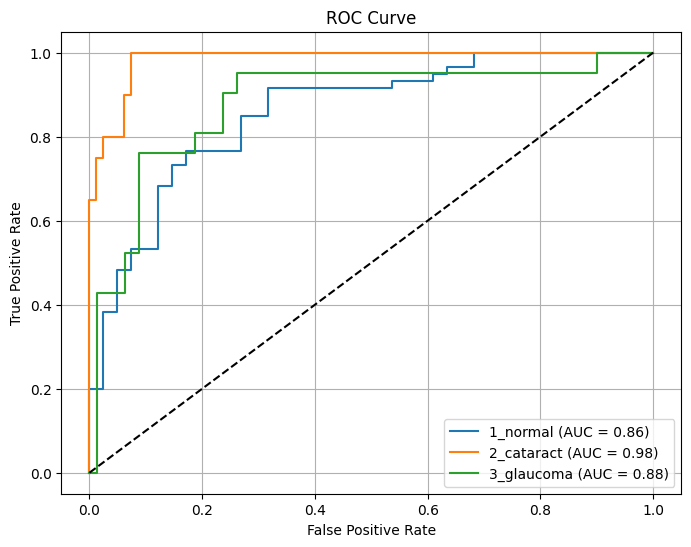

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

def plot_roc_curve(model, test_generator):
    # Get true labels as one-hot encoding
    num_classes = len(test_generator.class_indices)
    y_true = tf.keras.utils.to_categorical(test_generator.classes, num_classes=num_classes)

    # Get predicted probabilities
    y_pred_probs = model.predict(test_generator, verbose=1)  # Added verbose for debugging

    # Ensure we have output to plot
    if y_pred_probs.shape[1] != num_classes:
        print("❌ Mismatch between predicted output shape and number of classes!")
        print(f"Expected {num_classes} classes, but got {y_pred_probs.shape[1]} outputs.")
        return

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(test_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--')

    # Labels and formatting
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Call the function
plot_roc_curve(model, test_generator)

**Precision-Recall curve**

2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step


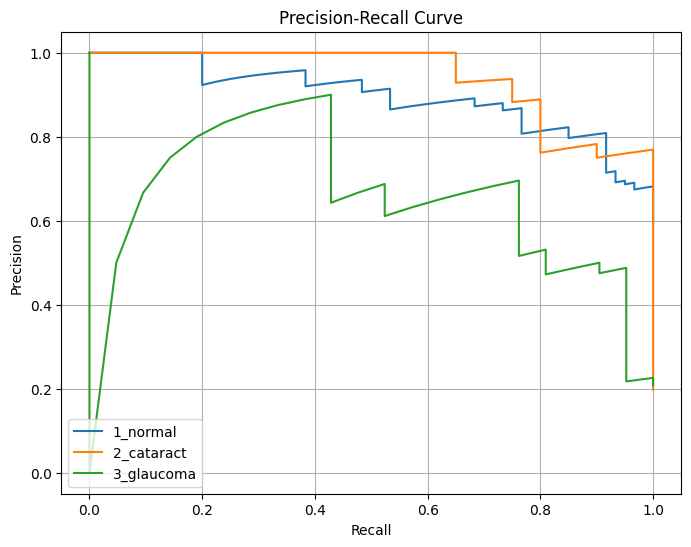

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import tensorflow as tf

def plot_precision_recall_curve(model, test_generator):
    # Get true labels as one-hot encoding
    num_classes = len(test_generator.class_indices)
    y_true = tf.keras.utils.to_categorical(test_generator.classes, num_classes=num_classes)

    # Get predicted probabilities
    y_pred_probs = model.predict(test_generator, verbose=1)  # Added verbose for debugging

    # Ensure we have correct number of outputs
    if y_pred_probs.shape[1] != num_classes:
        print("❌ Mismatch between predicted output shape and number of classes!")
        print(f"Expected {num_classes} classes, but got {y_pred_probs.shape[1]} outputs.")
        return

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(test_generator.class_indices.keys()):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'{class_label}')

    # Formatting
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

# Call the function
plot_precision_recall_curve(model, test_generator)

# **Experiment 5**
#**Balanced Dataset Testing with DenseNet-121 (CLAHE filtered)**
**No Fine-tuning to the base model**

**Training Strategy**

Unlike previous experiments where the DenseNet121 base model was eventually unfrozen for fine-tuning, this experiment **never unfreezes the base model**. This approach only uses DenseNet121 as a fixed feature extractor while **training only the custom classification layers** (GlobalAveragePooling, BatchNorm, Dropout, and Dense layers). Class weights have also been adjusted.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# --- Custom F1 Score Metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


# --- Paths ---
train_dir = './resized_clahe_images/train_augmented_clahe'
val_dir = './resized_clahe_images/val_clahe'
test_dir = './resized_clahe_images/test_clahe'

IMG_SIZE = (224, 224)

# --- Hyperparameters ---
BATCH_SIZE = 32
BASE_LR = 0.00033609  # Initial Learning Rate
DROPOUT_RATE_1 = 0.3
DROPOUT_RATE_2 = 0.5
DENSE_UNITS = 384
EPOCHS = 30

# --- Compute Class Weights for Imbalanced Dataset ---
class_weights = {
    0: 1.0,  # '1_normal' (baseline)
    1: 1.8,  # '2_cataract' (minority)
    2: 2.0   # '3_glaucoma' (minority)
}

# --- Build Model ---
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # ❌ Never Unfreeze Base Model ❌

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_RATE_1)(x)
    x = Dense(DENSE_UNITS, activation='relu')(x)
    x = Dropout(DROPOUT_RATE_2)(x)
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=BASE_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')]
    )
    return model


# --- Data Generators ---
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# --- Initialize the Model ---
model = build_model()

# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Stops if no improvement for 7 epochs
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,  # Reduce LR if no improvement for 5 epochs
    min_lr=1e-6,
    verbose=1
)

# --- Train the Model (Without Fine-Tuning) ---
print("🚀 Training the model with **frozen base layers** (No fine-tuning)...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights,  # Apply class weights here
    callbacks=[reduce_lr, early_stopping]
)

# --- Evaluate on Test Data ---
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(test_generator)
print(f"Test Results: Accuracy={test_accuracy:.2f}, Precision={test_precision:.2f}, Recall={test_recall:.2f}, Loss={test_loss:.2f}, AUC={test_auc:.2f}, F1 Score={test_f1:.2f}")


**Training and Validation Metrics Over Epochs**

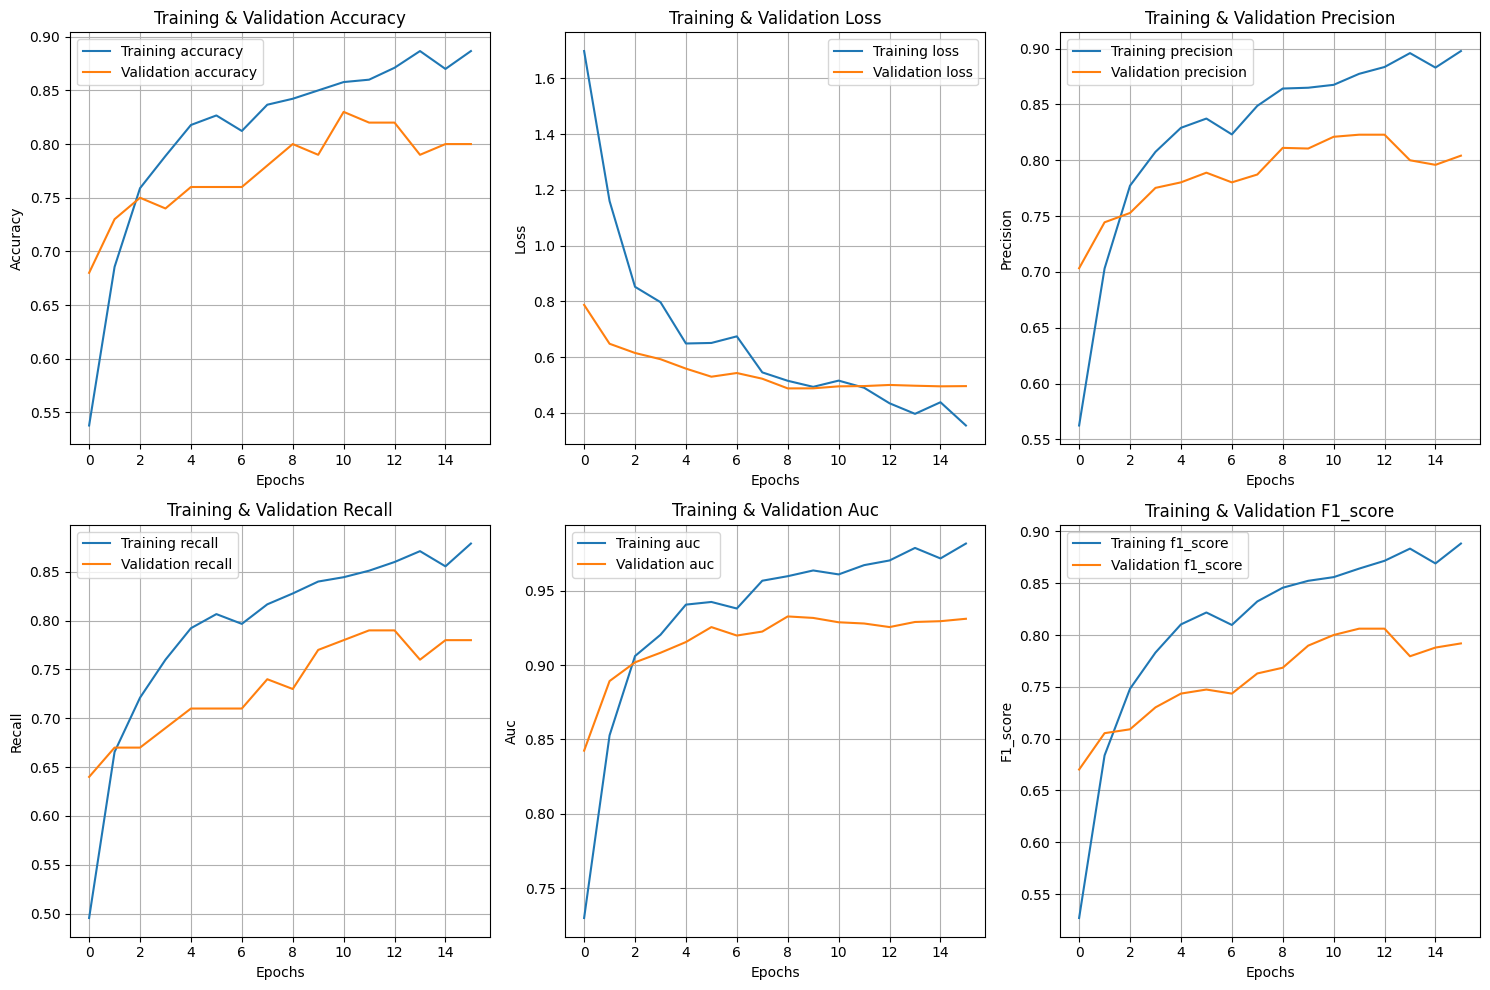

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot training history
def plot_training_history(history):
    # Define metrics to plot (excluding learning rate)
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc', 'f1_score']

    # Check available metrics in history
    available_metrics = [m for m in metrics if m in history.history]

    # Define the figure size dynamically
    num_metrics = len(available_metrics)
    rows = (num_metrics // 3) + (num_metrics % 3 > 0)  # Dynamic row calculation

    plt.figure(figsize=(15, 5 * rows))

    for i, metric in enumerate(available_metrics):
        plt.subplot(rows, 3, i + 1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training & Validation {metric.capitalize()}')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)

**Validation Accuracy & Loss over Epochs**

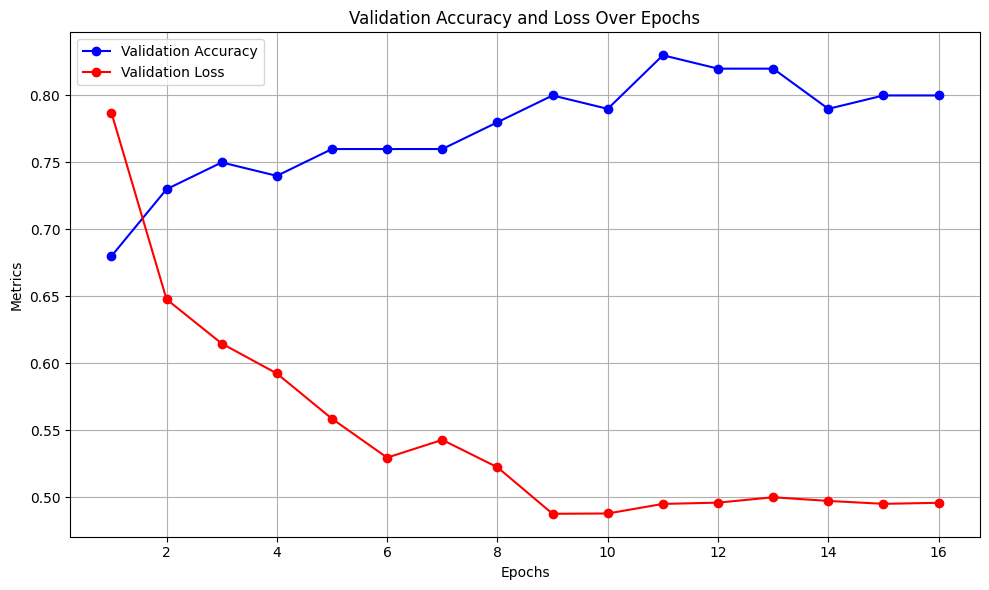

In [ ]:
import matplotlib.pyplot as plt

def plot_validation_metrics(history):
    """
    Plots validation accuracy and loss on the same graph for each epoch.
    """
    epochs = range(1, len(history.history['val_accuracy']) + 1)

    # Create a figure
    plt.figure(figsize=(10, 6))

    # Plot validation accuracy
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='blue', marker='o')

    # Plot validation loss
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red', marker='o')

    # Add labels, title, and legend
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Validation Accuracy and Loss Over Epochs')
    plt.legend()

    # Add grid
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function
plot_validation_metrics(history)

**Confusion Matrix & Classification Report**

4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step


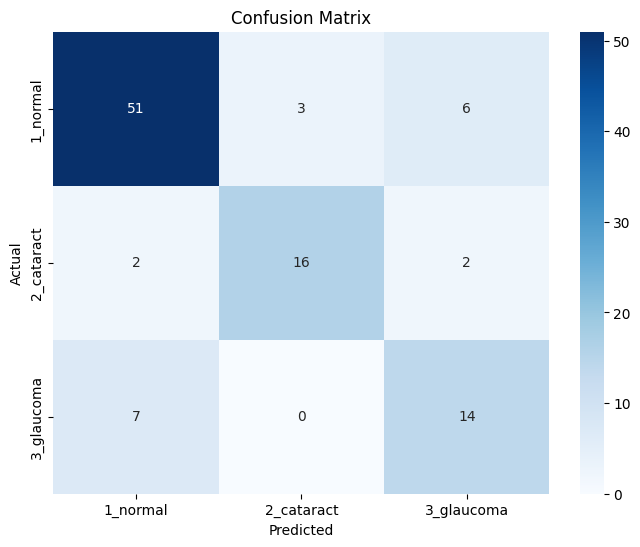


✅ Classification Report:

              precision    recall  f1-score   support

    1_normal       0.85      0.85      0.85        60
  2_cataract       0.84      0.80      0.82        20
  3_glaucoma       0.64      0.67      0.65        21

    accuracy                           0.80       101
   macro avg       0.78      0.77      0.77       101
weighted avg       0.80      0.80      0.80       101



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_generator):
    # Get true labels
    y_true = test_generator.classes

    # Get predicted probabilities
    y_pred_probs = model.predict(test_generator)

    # Convert probabilities to class predictions
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    labels = list(test_generator.class_indices.keys())

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("\n✅ Classification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=labels))

# Call the function
plot_confusion_matrix(model, test_generator)

**ROC curve**

4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step


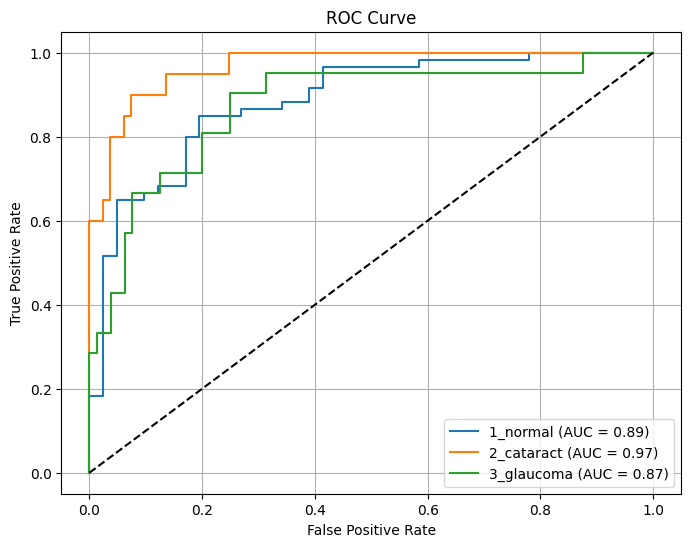

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

def plot_roc_curve(model, test_generator):
    # Get true labels as one-hot encoding
    num_classes = len(test_generator.class_indices)
    y_true = tf.keras.utils.to_categorical(test_generator.classes, num_classes=num_classes)

    # Get predicted probabilities
    y_pred_probs = model.predict(test_generator, verbose=1)  # Added verbose for debugging

    # Ensure we have output to plot
    if y_pred_probs.shape[1] != num_classes:
        print("❌ Mismatch between predicted output shape and number of classes!")
        print(f"Expected {num_classes} classes, but got {y_pred_probs.shape[1]} outputs.")
        return

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(test_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--')

    # Labels and formatting
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Call the function
plot_roc_curve(model, test_generator)

**Precision-Recall curve**

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step


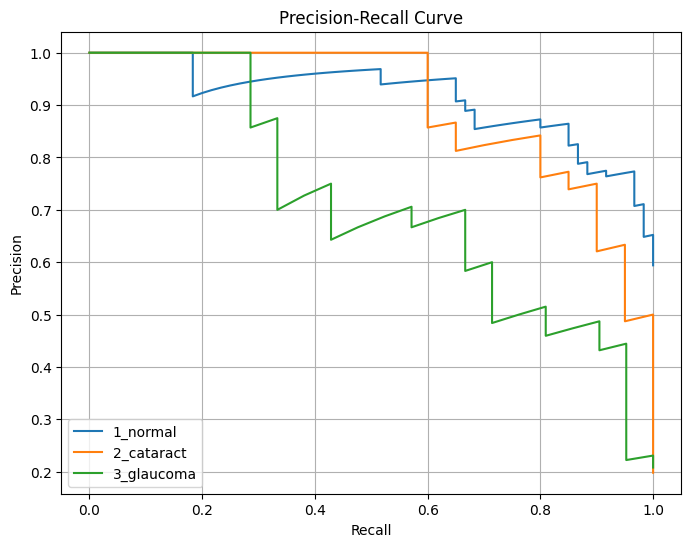

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import tensorflow as tf

def plot_precision_recall_curve(model, test_generator):
    # Get true labels as one-hot encoding
    num_classes = len(test_generator.class_indices)
    y_true = tf.keras.utils.to_categorical(test_generator.classes, num_classes=num_classes)

    # Get predicted probabilities
    y_pred_probs = model.predict(test_generator, verbose=1)  # Added verbose for debugging

    # Ensure we have correct number of outputs
    if y_pred_probs.shape[1] != num_classes:
        print("❌ Mismatch between predicted output shape and number of classes!")
        print(f"Expected {num_classes} classes, but got {y_pred_probs.shape[1]} outputs.")
        return

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(test_generator.class_indices.keys()):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'{class_label}')

    # Formatting
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

# Call the function
plot_precision_recall_curve(model, test_generator)

# **Experiment 6**
#**Balanced Dataset Testing with DenseNet-121 (CLAHE filtered)**
**No Fine-tuning to the base model (focal loss)**

**Training Strategy**

*   **New Loss Function:** Instead of standard categorical crossentropy, this experiment uses **Focal Loss** to handle class imbalance effectively. Focal Loss **down-weights easy examples** and puts **more focus on hard-to-classify samples**.

*   **Class weights** have been complemented with **per-class alpha values** of Normal: 0.20, Cataract: 0.35, Glaucoma: 0.65. These values ensure higher weight on Glaucoma, which is harder to classify.

*   **New Learning Rate Decay Strategy:** Instead of fixed learning rates, this experiment adds a Learning Rate Scheduler.

      **Strategy:**
        *   For the first 10 epochs: Learning rate remains stable.
        *   Every 5 epochs after epoch 10: Learning rate is divided by 4.
        *   ReduceLROnPlateau is still used if no improvement is observed.

*   Training is only enabled for the custom layers






In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import numpy as np

# --- Custom Macro F1 Score Metric ---
class MacroF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="macro_f1_score", **kwargs):
        super(MacroF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name="true_positives", shape=(num_classes,), initializer="zeros")
        self.false_positives = self.add_weight(name="false_positives", shape=(num_classes,), initializer="zeros")
        self.false_negatives = self.add_weight(name="false_negatives", shape=(num_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        for class_id in range(self.num_classes):
            true_pos = tf.reduce_sum(tf.cast((y_true == class_id) & (y_pred == class_id), tf.float32))
            false_pos = tf.reduce_sum(tf.cast((y_true != class_id) & (y_pred == class_id), tf.float32))
            false_neg = tf.reduce_sum(tf.cast((y_true == class_id) & (y_pred != class_id), tf.float32))

            # Update values: using one_hot vector to update the corresponding index
            self.true_positives.assign_add(tf.one_hot(class_id, self.num_classes) * true_pos)
            self.false_positives.assign_add(tf.one_hot(class_id, self.num_classes) * false_pos)
            self.false_negatives.assign_add(tf.one_hot(class_id, self.num_classes) * false_neg)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_scores = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return tf.reduce_mean(f1_scores)

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

# --- Focal Loss Implementation with per-class alpha ---
def focal_loss(alpha, gamma=2.0):
    """
    Focal Loss with per-class alpha.
    Parameters:
      alpha: A list or tensor of shape (num_classes,) with alpha values per class.
      gamma: Focusing parameter.
    Returns:
      A loss function.
    """
    alpha = tf.constant(alpha, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)  # Prevent log(0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        # weight has shape (batch_size, num_classes) due to broadcasting.
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)

    return loss_fn

# --- Paths ---
train_dir = './resized_clahe_images/train_augmented_clahe'
val_dir = './resized_clahe_images/val_clahe'
test_dir = './resized_clahe_images/test_clahe'

IMG_SIZE = (224, 224)

# --- Hyperparameters ---
BATCH_SIZE = 32
BASE_LR = 0.00033609  # Initial Learning Rate
DROPOUT_RATE_1 = 0.3
DROPOUT_RATE_2 = 0.5
DENSE_UNITS = 384
EPOCHS = 30

# --- Class Weights (Glaucoma is harder to classify) ---
class_weights = {
    0: 1.0,  # Normal
    1: 1.5,  # Cataract
    2: 2.0   # Glaucoma
}

# --- Build Model ---
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # No fine-tuning yet

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_RATE_1)(x)
    x = Dense(DENSE_UNITS, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(DROPOUT_RATE_2)(x)
    output_layer = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile with Focal Loss and Macro F1 Score.
    # Set per-class alpha values: [0.20, 0.35, 0.65]
    macro_f1 = MacroF1Score(num_classes=3)
    model.compile(
        optimizer=Adam(learning_rate=BASE_LR),
        loss=focal_loss(alpha=[0.20, 0.35, 0.65], gamma=2.0),
        metrics=['accuracy',
                 Precision(name='precision'),
                 Recall(name='recall'),
                 AUC(name='auc'),
                 macro_f1]
    )
    return model

# --- Data Generators ---
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# --- Initialize the Model ---
model = build_model()

# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1,
    min_delta=1e-3
)

# Learning Rate Scheduler: Reduce LR every 5 epochs after 10 epochs
def lr_schedule(epoch, lr):
    if epoch >= 10 and epoch % 5 == 0:
        return lr / 4
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# --- Train the Model (Without Fine-Tuning) ---
print("🚀 Training the model with **frozen base layers** (No fine-tuning)...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights,  # Apply class weights
    callbacks=[reduce_lr, early_stopping, lr_scheduler]
)

# --- Evaluate on Test Data ---
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy, test_precision, test_recall, test_auc, test_macro_f1 = model.evaluate(test_generator)
print(f"Test Results: Accuracy={test_accuracy:.2f}, Precision={test_precision:.2f}, Recall={test_recall:.2f}, "
      f"Loss={test_loss:.2f}, AUC={test_auc:.2f}, Macro F1 Score={test_macro_f1:.2f}")


**Training and Validation Metrics Over Epochs**

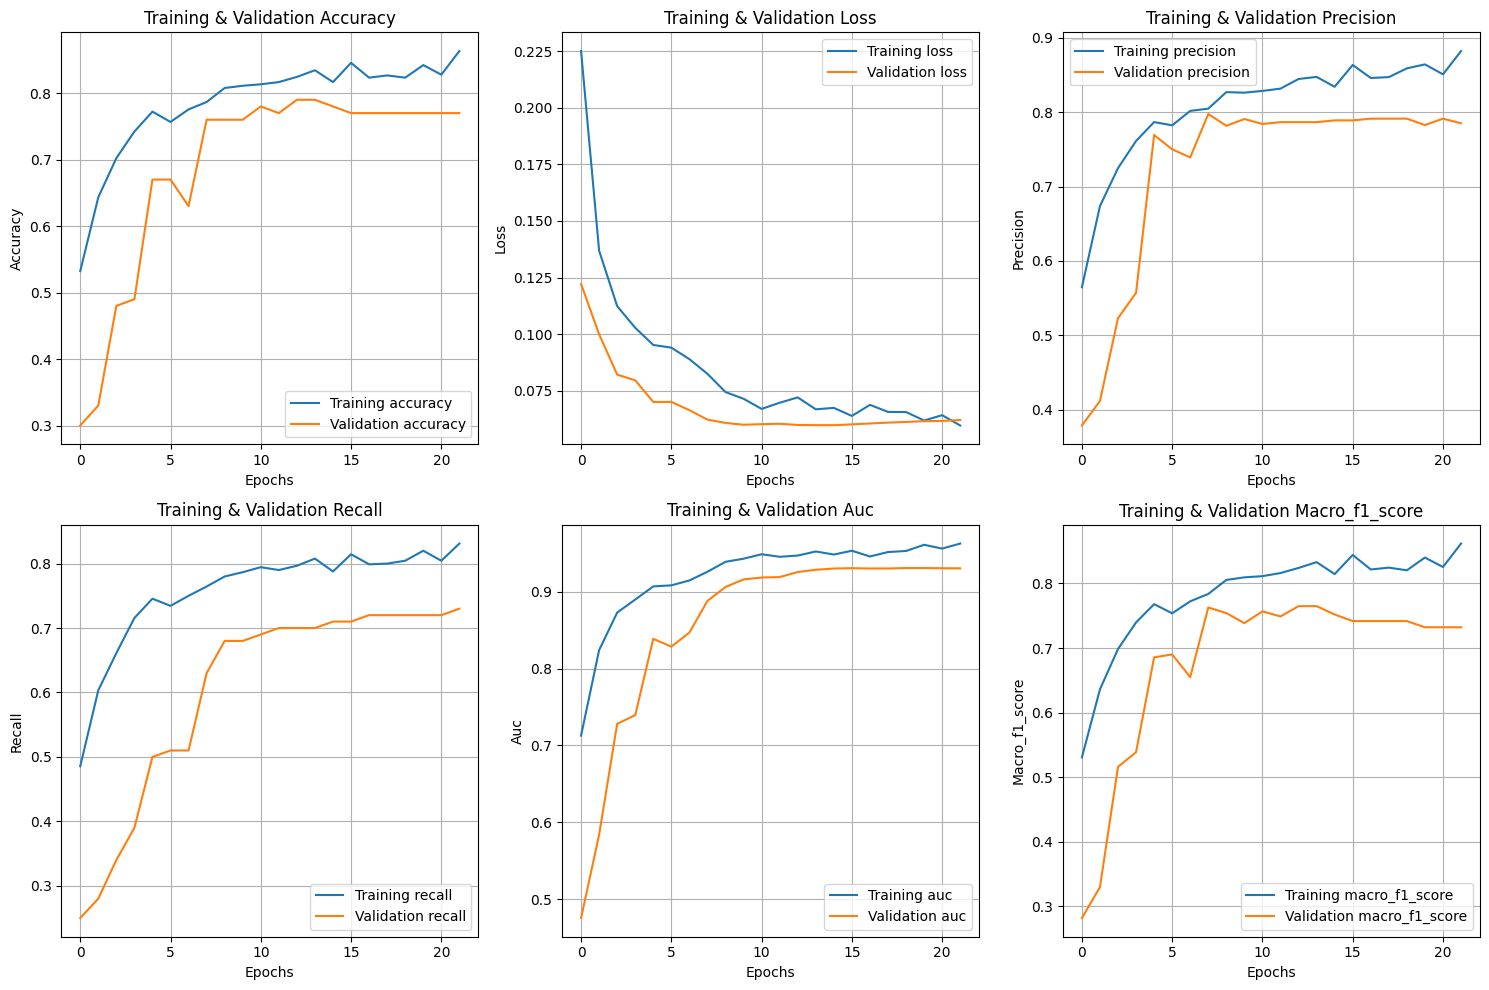

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc', 'macro_f1_score']

    available_metrics = [m for m in metrics if m in history.history]

    num_metrics = len(available_metrics)
    rows = (num_metrics // 3) + (num_metrics % 3 > 0)

    plt.figure(figsize=(15, 5 * rows))

    for i, metric in enumerate(available_metrics):
        plt.subplot(rows, 3, i + 1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training & Validation {metric.capitalize()}')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


**Validation Accuracy & Loss over Epochs**

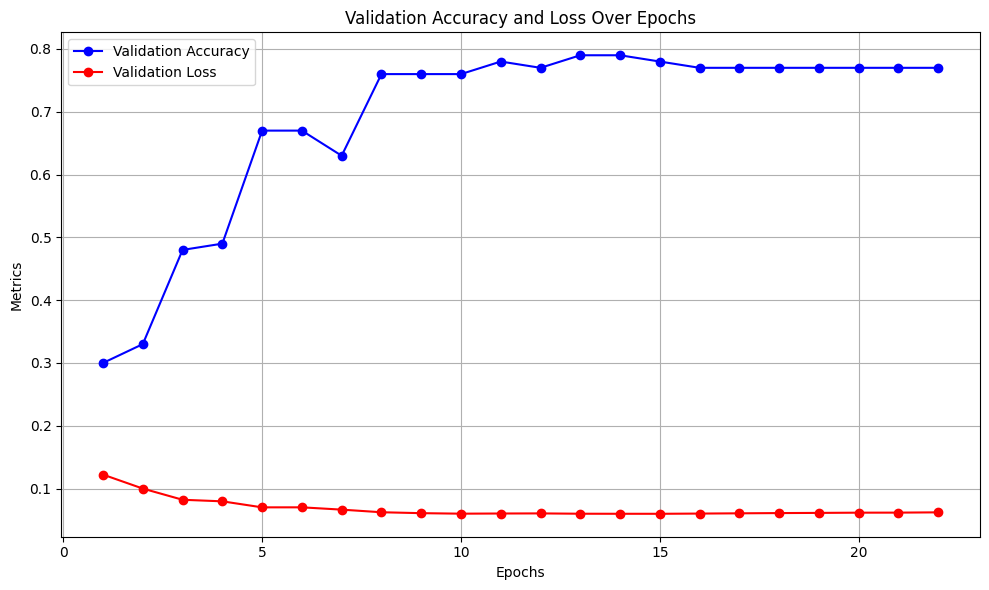

In [ ]:
import matplotlib.pyplot as plt

def plot_validation_metrics(history):
    epochs = range(1, len(history.history['val_accuracy']) + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='blue', marker='o')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red', marker='o')

    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Validation Accuracy and Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_validation_metrics(history)

**Confusion Matrix & Classification Report**

4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step


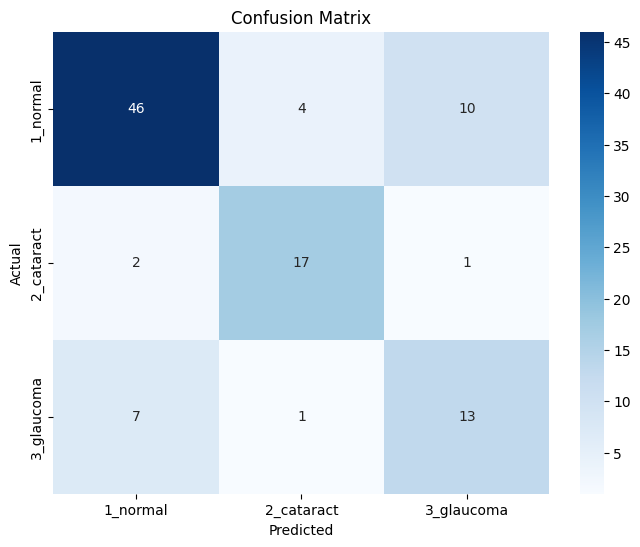


✅ Classification Report:

              precision    recall  f1-score   support

    1_normal       0.84      0.77      0.80        60
  2_cataract       0.77      0.85      0.81        20
  3_glaucoma       0.54      0.62      0.58        21

    accuracy                           0.75       101
   macro avg       0.72      0.75      0.73       101
weighted avg       0.76      0.75      0.76       101



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_generator):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    labels = list(test_generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n✅ Classification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=labels))

# Call the function
plot_confusion_matrix(model, test_generator)


**ROC curve**

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step


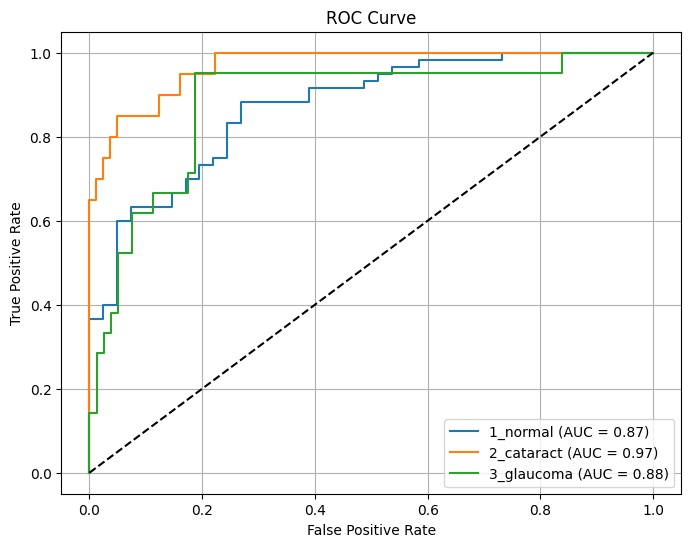

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

def plot_roc_curve(model, test_generator):
    num_classes = len(test_generator.class_indices)
    y_true = tf.keras.utils.to_categorical(test_generator.classes, num_classes=num_classes)
    y_pred_probs = model.predict(test_generator, verbose=1)

    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(test_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Call the function
plot_roc_curve(model, test_generator)


**Precision-Recall curve**

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


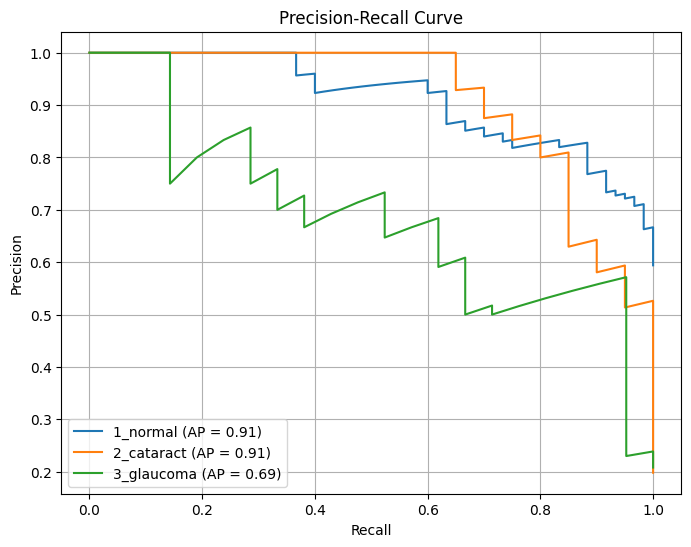

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import tensorflow as tf

def plot_precision_recall_curve(model, test_generator):
    num_classes = len(test_generator.class_indices)
    y_true = tf.keras.utils.to_categorical(test_generator.classes, num_classes=num_classes)
    y_pred_probs = model.predict(test_generator, verbose=1)

    plt.figure(figsize=(8, 6))
    for i, class_label in enumerate(test_generator.class_indices.keys()):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
        ap = average_precision_score(y_true[:, i], y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'{class_label} (AP = {ap:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

# Call the function
plot_precision_recall_curve(model, test_generator)


# **Experiment 7**
#**Balanced Dataset Testing with EfficientNetB0 (CLAHE filtered)**
**Fine-tuning to the last 110 layers of the base model (focal loss)**

**Training Strategy**

*  **New Backbone Architecture:** Instead of DenseNet121, this experiment uses **EfficientNetB0**, which is lighter and more efficient.
*  **Unfreezing More Layers:** Instead of unfreezing only a small part of the base model, this experiment unfreezes the last 110 layers for fine-tuning.
*  **Focal Loss used Instead of Categorical Crossentropy:** custom alpha values along with class weights are used
*  **New Batch Size Strategy:**
      *  Phase 1 (Feature Extraction - Initial Training): Batch Size = 64. Helps stabilize training during the frozen feature extraction phase.
      *  Phase 2 (Fine-Tuning): Batch Size = 32. A smaller batch size (32) improves fine-tuning stability, reducing noise in gradient updates.

*  **Two-Stage Learning Rate Adjustment:**
      *  **Warm-Up Phase:** First 20 epochs exponentially increase the learning rate. Prevents premature convergence of the pretrained weights.
      *  **Stabilization Phase:** After warm-up, the learning rate fixes at 5e-6 for fine-tuning in a controlled manner.  














In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np

# Define dataset paths
train_dir = './resized_clahe_images/train_augmented_clahe'
val_dir = './resized_clahe_images/val_clahe'
test_dir = './resized_clahe_images/test_clahe'

# Define image size and batch sizes
IMG_SIZE = (224, 224)
BATCH_SIZE_TRAIN = 64  # Batch size for initial training
BATCH_SIZE_FINE_TUNE = 32  # Batch size for fine-tuning

# Add class weights
class_weights = {0: 1.0, 1: 1.5, 2: 2.0}  # Normal, Cataract, Glaucoma

# Define alpha values for Focal Loss (adjust class importance within the loss)
alpha = [0.20, 0.35, 0.65]  # Customize these values based on your dataset

# Define Focal Loss with custom alpha
def focal_loss(alpha, gamma=2.0):
    alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        ce_loss = -y_true * tf.math.log(y_pred)
        focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * ce_loss
        return tf.reduce_sum(focal_loss, axis=-1)
    return loss_fn

# Load dataset (Initial Training)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE_TRAIN, label_mode="categorical", shuffle=True).prefetch(buffer_size=AUTOTUNE)
val_dataset = image_dataset_from_directory(val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE_TRAIN, label_mode="categorical").prefetch(buffer_size=AUTOTUNE)
test_dataset = image_dataset_from_directory(test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE_TRAIN, label_mode="categorical").prefetch(buffer_size=AUTOTUNE)

# Define hyperparameters for the custom layer
DENSE_UNITS = 512
DROPOUT_RATE_1 = 0.2
DROPOUT_RATE_2 = 0.4

# Load EfficientNet model (transfer learning)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model initially

# Build model (Initial Training)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Normalizing before the dense layer
x = Dropout(DROPOUT_RATE_1)(x)
x = Dense(DENSE_UNITS, activation='relu', name='dense')(x)
x = Dropout(DROPOUT_RATE_2)(x)
output = Dense(3, activation='softmax', name='dense_1')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model with Focal Loss
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00033609),
              loss=focal_loss(alpha=alpha),
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train model (Initial Training with Frozen Base)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# ------------------- Fine-Tuning ------------------- #
# **Unfreeze the last 110 layers**
for layer in base_model.layers[-110:]:
    layer.trainable = True

# **Freeze BatchNorm Layers**
for layer in model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

# ✅ Extract trained weights from the existing head
dense_weights = model.get_layer('dense').get_weights()
output_weights = model.get_layer('dense_1').get_weights()

# ✅ Rebuild the classification head without Dropout
inputs = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(DENSE_UNITS, activation='relu', name='dense')(x)
x = Dense(3, activation='softmax', name='dense_1')(x)

fine_tune_model = Model(inputs=inputs, outputs=x)

# ✅ Transfer the trained weights
fine_tune_model.get_layer('dense').set_weights(dense_weights)
fine_tune_model.get_layer('dense_1').set_weights(output_weights)

# **New Learning Rate Schedule: Warm-up then Stabilize at 5e-6**
warmup_epochs = 20  # Warm-up phase
total_epochs = 50  # Fine-tuning phase

def lr_schedule(epoch):
    if epoch < warmup_epochs:
        return 1e-7 * (10 ** (epoch / warmup_epochs))  # Exponential increase during warm-up
    return 5e-6  # Fixate learning rate at 5e-6 after warm-up

lr_callback = LearningRateScheduler(lr_schedule)

# **Recompile fine-tune model**
optimizer = keras.optimizers.Adam(learning_rate=1e-7, clipnorm=1.0)  # Reset optimizer state
fine_tune_model.compile(
    optimizer=optimizer,
    loss=focal_loss(alpha=alpha),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# **Load Dataset for Fine-Tuning (with 32 Batch Size)**
train_dataset_finetune = image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE_FINE_TUNE, label_mode="categorical", shuffle=True).prefetch(buffer_size=AUTOTUNE)
val_dataset_finetune = image_dataset_from_directory(val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE_FINE_TUNE, label_mode="categorical").prefetch(buffer_size=AUTOTUNE)

# **Fine-Tune the Model**
fine_tune_history = fine_tune_model.fit(train_dataset_finetune, validation_data=val_dataset_finetune, epochs=total_epochs, class_weight=class_weights, callbacks=[early_stopping, lr_callback])

# Evaluate the fine-tuned model
results = fine_tune_model.evaluate(test_dataset)
print("Test Results:", dict(zip(fine_tune_model.metrics_names, results)))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Training and Validation Accuracy/Loss over Epochs**

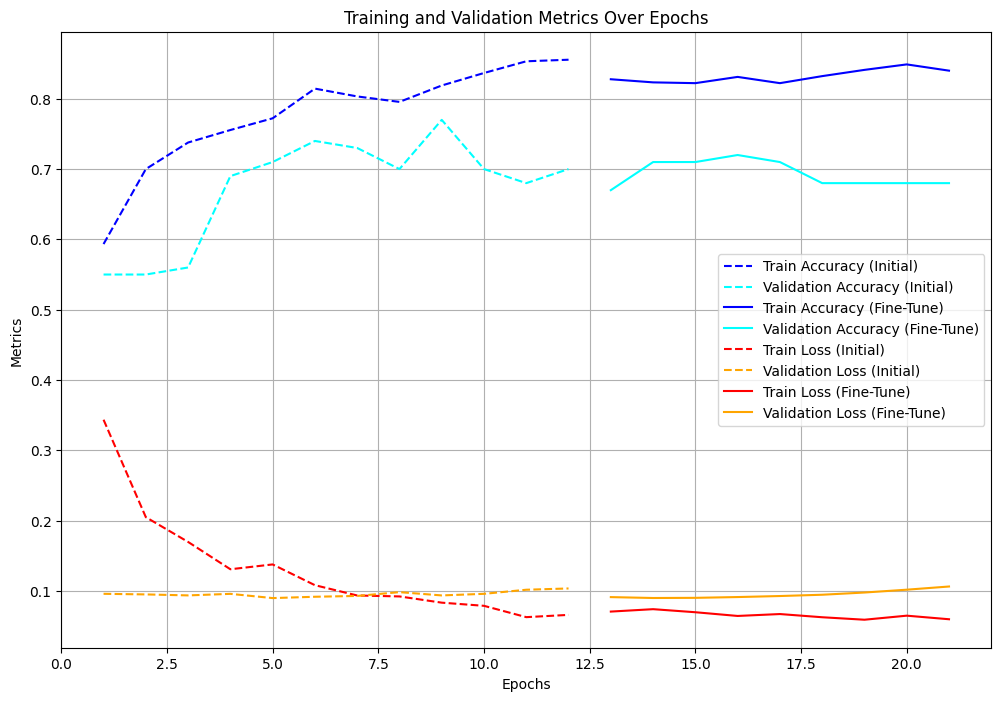

In [ ]:
def plot_combined_metrics(initial_history, fine_tune_history=None):
    """
    Plots training and validation accuracy and loss in the same plot.
    """
    epochs_initial = range(1, len(initial_history.history['accuracy']) + 1)
    epochs_fine_tune = (
        range(len(epochs_initial) + 1, len(epochs_initial) + 1 + len(fine_tune_history.history['accuracy']))
        if fine_tune_history
        else []
    )

    plt.figure(figsize=(12, 8))

    # Plot accuracy
    plt.plot(epochs_initial, initial_history.history['accuracy'], label='Train Accuracy (Initial)', linestyle='--', color='blue')
    plt.plot(epochs_initial, initial_history.history['val_accuracy'], label='Validation Accuracy (Initial)', linestyle='--', color='cyan')

    if fine_tune_history:
        plt.plot(epochs_fine_tune, fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-Tune)', color='blue')
        plt.plot(epochs_fine_tune, fine_tune_history.history['val_accuracy'], label='Validation Accuracy (Fine-Tune)', color='cyan')

    # Plot loss
    plt.plot(epochs_initial, initial_history.history['loss'], label='Train Loss (Initial)', linestyle='--', color='red')
    plt.plot(epochs_initial, initial_history.history['val_loss'], label='Validation Loss (Initial)', linestyle='--', color='orange')

    if fine_tune_history:
        plt.plot(epochs_fine_tune, fine_tune_history.history['loss'], label='Train Loss (Fine-Tune)', color='red')
        plt.plot(epochs_fine_tune, fine_tune_history.history['val_loss'], label='Validation Loss (Fine-Tune)', color='orange')

    # Add labels, legend, and title
    plt.title('Training and Validation Metrics Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()


# Call the function with initial training history and fine-tune history
plot_combined_metrics(history, fine_tune_history)

**Training and Validation F1-score over Epochs**

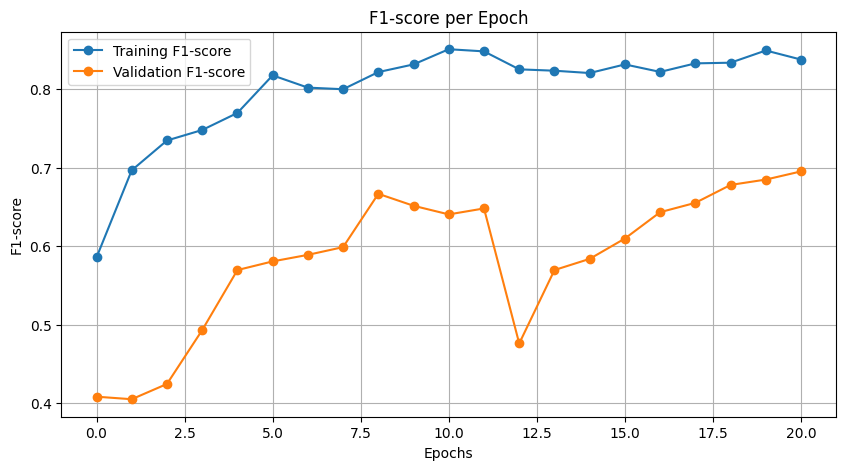

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute F1-score
def compute_f1(precision, recall):
    epsilon = 1e-7  # Small value to prevent division by zero
    return (2 * precision * recall) / (precision + recall + epsilon)

# Function to plot F1-score per epoch
def plot_f1_score(history, fine_tune_history=None):
    # Extract precision and recall from history
    precision = np.array(history.history['precision'])
    recall = np.array(history.history['recall'])
    val_precision = np.array(history.history['val_precision'])
    val_recall = np.array(history.history['val_recall'])

    # Compute F1-score
    f1_train = compute_f1(precision, recall)
    f1_val = compute_f1(val_precision, val_recall)

    # If fine-tuning history is provided, extend the plots
    if fine_tune_history:
        fine_precision = np.array(fine_tune_history.history['precision'])
        fine_recall = np.array(fine_tune_history.history['recall'])
        fine_val_precision = np.array(fine_tune_history.history['val_precision'])
        fine_val_recall = np.array(fine_tune_history.history['val_recall'])

        f1_train_fine = compute_f1(fine_precision, fine_recall)
        f1_val_fine = compute_f1(fine_val_precision, fine_val_recall)

        f1_train = np.concatenate([f1_train, f1_train_fine])
        f1_val = np.concatenate([f1_val, f1_val_fine])

    # Plot the F1-score
    plt.figure(figsize=(10, 5))
    plt.plot(f1_train, label='Training F1-score', marker='o')
    plt.plot(f1_val, label='Validation F1-score', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.title('F1-score per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot F1-score
plot_f1_score(history, fine_tune_history)


**Confusion Matrix & Classification Report**

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step


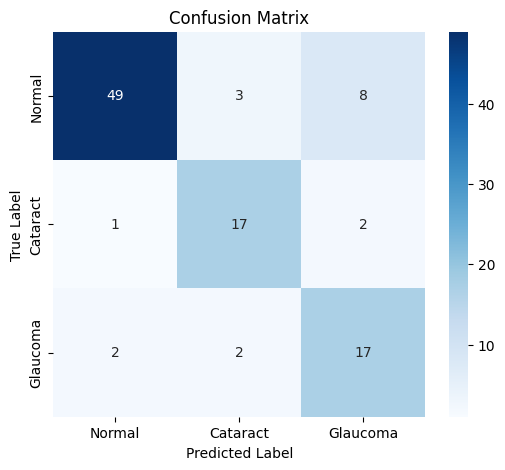

              precision    recall  f1-score   support

      Normal       0.94      0.82      0.88        60
    Cataract       0.77      0.85      0.81        20
    Glaucoma       0.63      0.81      0.71        21

    accuracy                           0.82       101
   macro avg       0.78      0.83      0.80       101
weighted avg       0.84      0.82      0.83       101



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels and predictions
y_true = []
y_pred = []

# Loop through the test dataset and collect labels & predictions
for images, labels in test_dataset:
    # True labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))

    # Predictions
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class names
class_names = ["Normal", "Cataract", "Glaucoma"]

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


**ROC curve**

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 452ms/step


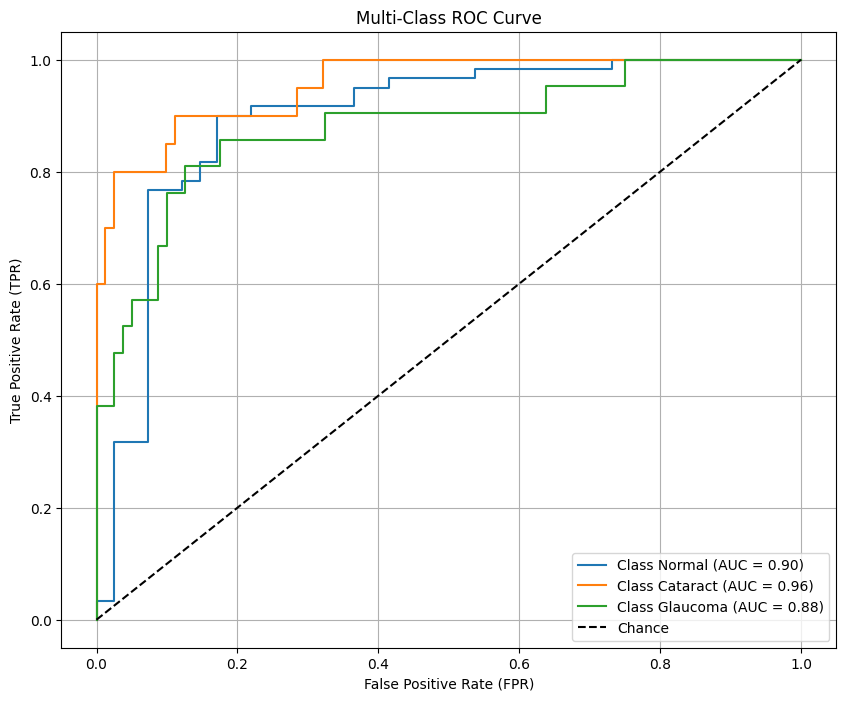

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(model, test_dataset, class_names):
    # Extract true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        y_pred.extend(model.predict(images))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Binarize the true labels
    y_true_binarized = label_binarize(np.argmax(y_true, axis=1), classes=range(len(class_names)))

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')

    # Add labels, title, and legend
    plt.title('Multi-Class ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Class names in your dataset
class_names = ['Normal', 'Cataract', 'Glaucoma']

# Generate the ROC plot
plot_roc_curve(model, test_dataset, class_names)

**Test Predictions Visualization**

In [ ]:
import random
import matplotlib.pyplot as plt

# Get the class names
class_labels = ['Normal', 'Cataract', 'Glaucoma']  # Replace with your actual class names

# Make predictions on the test dataset
y_true = []
y_pred = []
all_images = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images))
    all_images.extend(images.numpy())  # Collect all images for visualization

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get predicted class labels
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(y_true, axis=1)

# Randomly sample 20 test images
sample_indices = random.sample(range(len(true_labels)), 20)

plt.figure(figsize=(20, 15))
for i, idx in enumerate(sample_indices):
    # Get the image, true label, and predicted label
    img = all_images[idx].astype('uint8')
    true_label = class_labels[true_labels[idx]]
    pred_label = class_labels[predicted_labels[idx]]

    # Display the image with title
    plt.subplot(4, 5, i + 1)  # Adjusted for a 4x5 grid to display 20 images
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)

plt.tight_layout()
plt.show()

# **Experiment 8**
#**Balanced Dataset Testing with EfficientNetB0 (CLAHE filtered)**
**Fine-tuning to the last 50 layers of the base model (loss = categorical crossentropy)**

**Training Strategy**

*  Only the **last 50 layers** of EfficientNetB0 are **unfrozen** during fine-tuning.
*  **Lower Batch Size for Fine-Tuning:** Batch size is reduced from 32 → 16 during fine-tuning.
*   A lower stable **learning rate of 1e-6** is used during fine-tuning.
*  **Loss Function: categorical crossentropy**





In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC

# --- Custom F1 Score Metric ---
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define dataset paths
train_dir = './resized_clahe_images/train_augmented_clahe'
val_dir   = './resized_clahe_images/val_clahe'
test_dir  = './resized_clahe_images/test_clahe'

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # Initial batch size

# Add class weights (Normal, Cataract, Glaucoma)
class_weights = {0: 1.0, 1: 1.5, 2: 2.0}

# Load train & validation datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# --- Load test dataset with shuffle set to False ---
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False  # Ensures consistent ordering for evaluation
)

# Save test class names for later use (e.g., in confusion matrix)
test_class_names = test_dataset.class_names

# Optimize dataset loading with prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Define hyperparameters for the custom layer
DROPOUT_RATE_1 = 0.3
DROPOUT_RATE_2 = 0.5
DENSE_UNITS    = 512

# Load EfficientNet model (transfer learning)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model initially
base_model.trainable = False

# Build model with custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Normalizing before the dense layer
x = Dropout(DROPOUT_RATE_1)(x)
x = Dense(DENSE_UNITS, activation='relu')(x)
x = Dropout(DROPOUT_RATE_2)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model for initial training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00033609),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')]
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train model (Initial Training with Frozen Base)
history_initial = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# ------------------- Fine-Tuning ------------------- #

# Unfreeze the last 50 layers of the base model
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')]
)

# Reduce batch size for fine-tuning for more precise updates
BATCH_SIZE_FINE_TUNE = 16
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE_FINE_TUNE,
    label_mode="categorical"
)
val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE_FINE_TUNE,
    label_mode="categorical"
)

# Optimize dataset loading again
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset   = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Fine-tune model
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test dataset
results = model.evaluate(test_dataset)
print("Test Results:", dict(zip(model.metrics_names, results)))


**Training and Validation Metrics over Epochs**

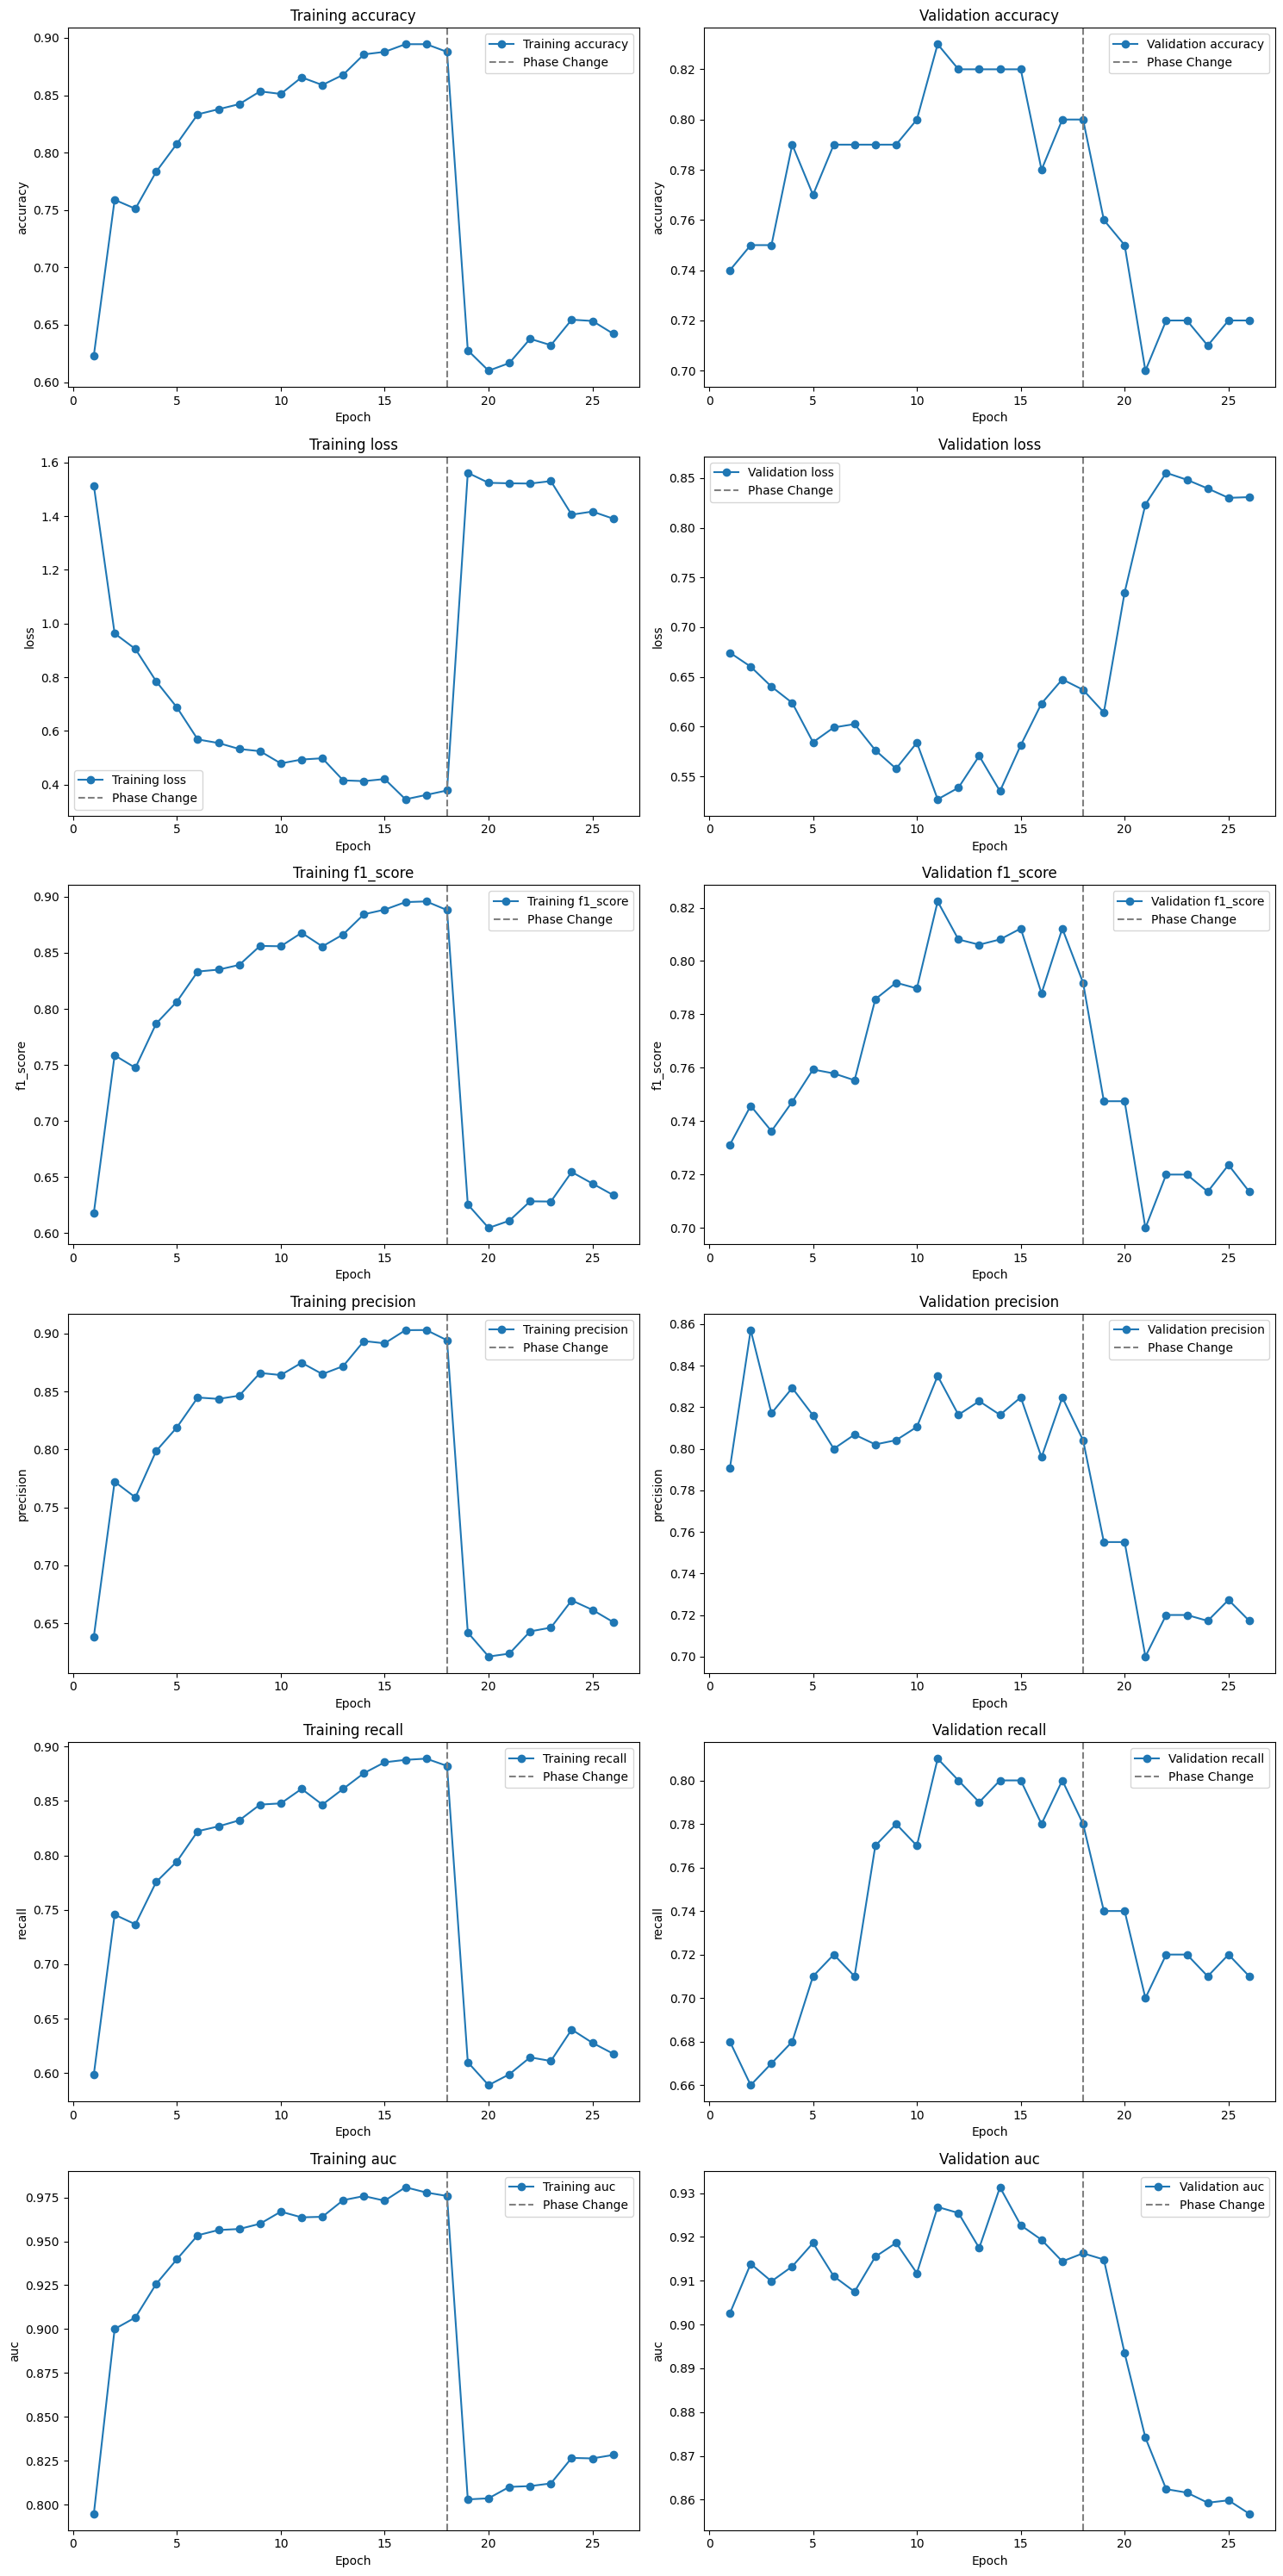

In [ ]:
import matplotlib.pyplot as plt

# List of metrics you want to plot.
metrics = ['accuracy', 'loss', 'f1_score', 'precision', 'recall', 'auc']

# Create dictionaries to hold the combined history (training and validation) for each metric.
combined_train = {}
combined_val = {}

# For each metric, concatenate the initial training history with the fine-tuning history.
for metric in metrics:
    # Get training values (assumes both history objects exist)
    train_initial = history_initial.history[metric]
    train_finetune = history_finetune.history[metric]
    combined_train[metric] = train_initial + train_finetune

    # Get validation values (keys prefixed with 'val_')
    val_initial = history_initial.history['val_' + metric]
    val_finetune = history_finetune.history['val_' + metric]
    combined_val[metric] = val_initial + val_finetune

# Total number of combined epochs.
total_epochs = len(combined_train['accuracy'])
epochs_combined = list(range(1, total_epochs + 1))

# Determine the epoch number where the initial training phase ended.
phase_change_epoch = len(history_initial.history['accuracy'])

# Create a 6x2 grid of subplots:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15, 30))

# Loop over the metrics and plot training (left column) and validation (right column) curves.
for i, metric in enumerate(metrics):
    # Left: Training metric.
    axs[i, 0].plot(epochs_combined, combined_train[metric], marker='o', label='Training ' + metric)
    axs[i, 0].axvline(x=phase_change_epoch, color='gray', linestyle='--', label='Phase Change')
    axs[i, 0].set_xlabel('Epoch')
    axs[i, 0].set_ylabel(metric)
    axs[i, 0].set_title('Training ' + metric)
    axs[i, 0].legend()

    # Right: Validation metric.
    axs[i, 1].plot(epochs_combined, combined_val[metric], marker='o', label='Validation ' + metric)
    axs[i, 1].axvline(x=phase_change_epoch, color='gray', linestyle='--', label='Phase Change')
    axs[i, 1].set_xlabel('Epoch')
    axs[i, 1].set_ylabel(metric)
    axs[i, 1].set_title('Validation ' + metric)
    axs[i, 1].legend()

plt.tight_layout()
plt.show()



**Confusion Matrix & Classification Report**

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


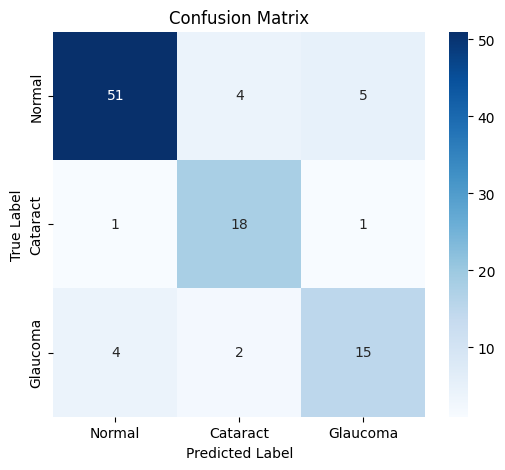

              precision    recall  f1-score   support

      Normal       0.91      0.85      0.88        60
    Cataract       0.75      0.90      0.82        20
    Glaucoma       0.71      0.71      0.71        21

    accuracy                           0.83       101
   macro avg       0.79      0.82      0.80       101
weighted avg       0.84      0.83      0.83       101



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels and predictions
y_true = []
y_pred = []

# Loop through the test dataset and collect labels & predictions
for images, labels in test_dataset:
    # True labels
    y_true.extend(np.argmax(labels.numpy(), axis=1))

    # Predictions
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class names
class_names = ["Normal", "Cataract", "Glaucoma"]

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

**ROC curve**

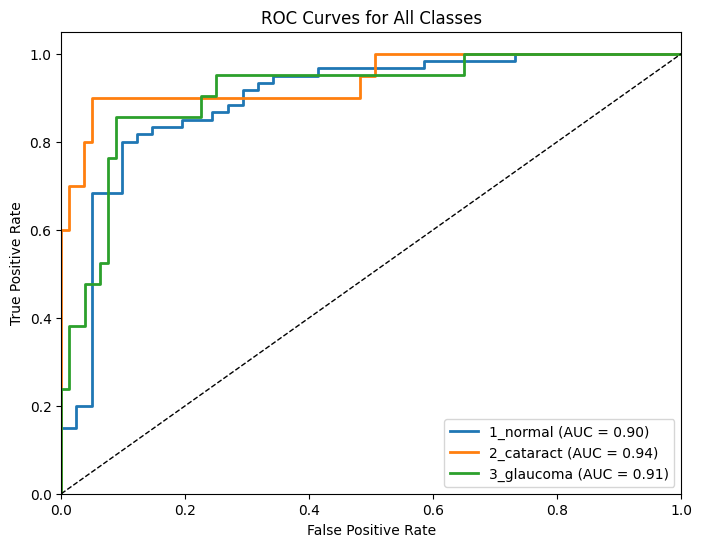

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    # Compute ROC curve and ROC area for class i.
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve for class i
    plt.plot(fpr, tpr, lw=2, label=f'{test_class_names[i]} (AUC = {roc_auc:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend(loc="lower right")
plt.show()


**Precision-Recall curve**

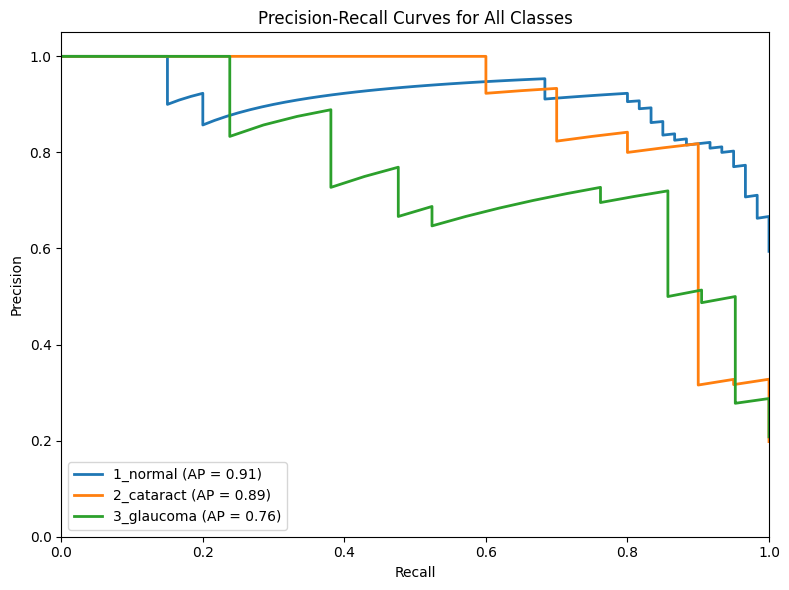

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    # Compute precision-recall curve and average precision for class i.
    precision_vals, recall_vals, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true[:, i], y_pred_probs[:, i])

    # Plot all curves on the same axes
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{test_class_names[i]} (AP = {ap:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Classes')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()



**Training and Validation Accuracy/Loss over Epochs**

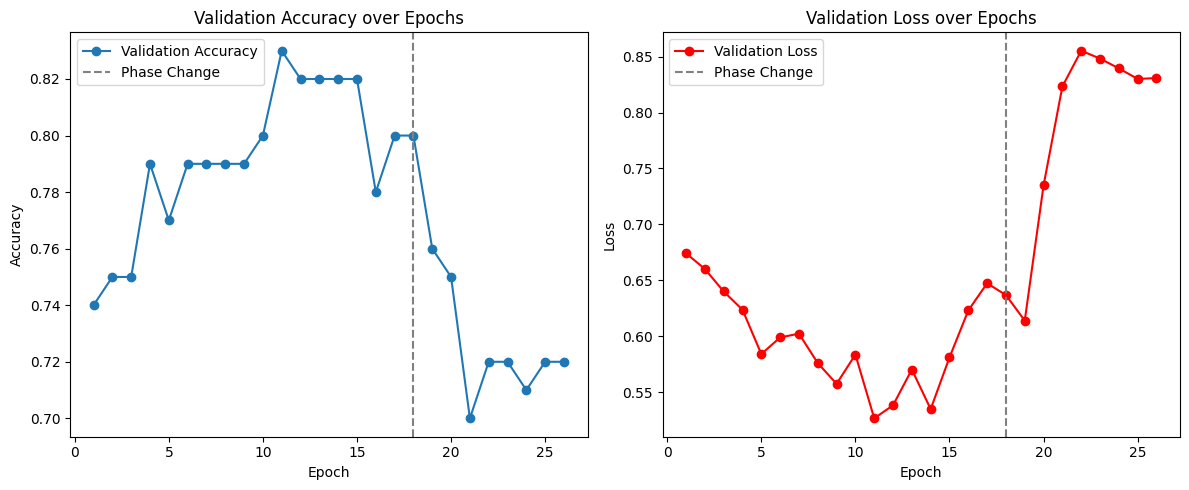

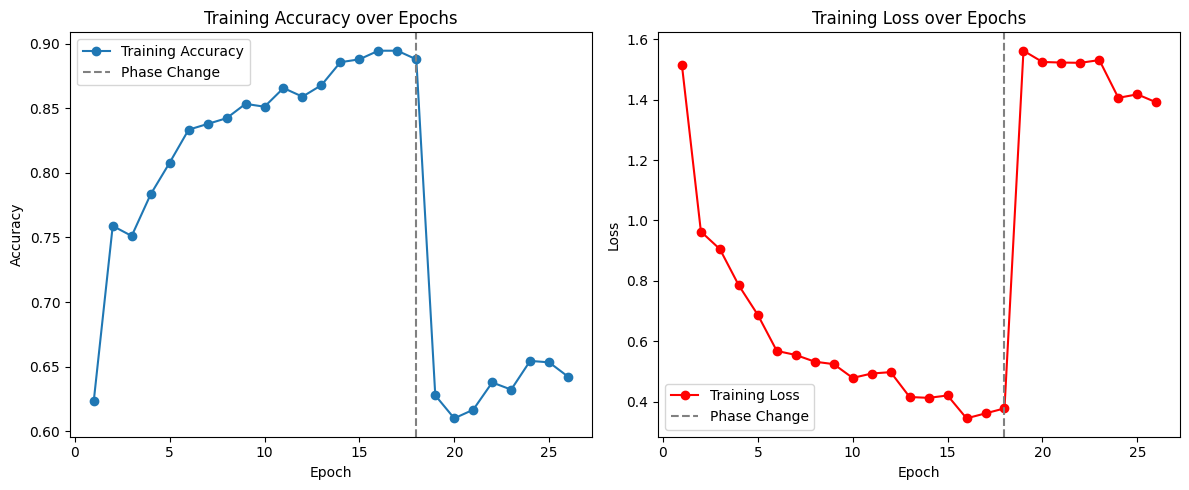

In [ ]:
import matplotlib.pyplot as plt

# --- Combine the histories from initial training and fine tuning ---
initial_epochs = len(history_initial.history['accuracy'])
finetune_epochs = len(history_finetune.history['accuracy'])
total_epochs = initial_epochs + finetune_epochs

# Combine training metrics
train_accuracy = history_initial.history['accuracy'] + history_finetune.history['accuracy']
train_loss     = history_initial.history['loss'] + history_finetune.history['loss']

# Combine validation metrics
val_accuracy = history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
val_loss     = history_initial.history['val_loss'] + history_finetune.history['val_loss']

# Create an epoch list
epochs = list(range(1, total_epochs + 1))

# --- Graph 1: Validation Accuracy and Loss Over Epochs ---
plt.figure(figsize=(12, 5))
# Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.axvline(x=initial_epochs, color='gray', linestyle='--', label='Phase Change')
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, marker='o', color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.axvline(x=initial_epochs, color='gray', linestyle='--', label='Phase Change')
plt.legend()

plt.tight_layout()
plt.show()

# --- Graph 2: Training Accuracy and Loss Over Epochs ---
plt.figure(figsize=(12, 5))
# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.axvline(x=initial_epochs, color='gray', linestyle='--', label='Phase Change')
plt.legend()

# Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', color='red', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.axvline(x=initial_epochs, color='gray', linestyle='--', label='Phase Change')
plt.legend()

plt.tight_layout()
plt.show()
